To previous notebook: [Network Traffic EDA](./network-traffic-eda.ipynb)<br/>
To the README: [README](./README.md)<br/>

--------------------------------------------------------------------------------

In [1]:
# Import base packages
from sklearn.model_selection import GridSearchCV
from pipe import select, where, sort

import utils.style as style
from utils.confusion import confusion_matrix
from utils.network_traffic import File, Col
from utils.evaluation import evaluate_model, evaluate_hpt, compare_models

# Network Traffic: Machine Learning, Part 1

## Setup: Score and Best Model Tracking

In [2]:
# Fix beta and scorer
from sklearn.metrics import fbeta_score, make_scorer

BETA = 10.0
AVERAGE = 'binary'
scorer = make_scorer(fbeta_score, beta=BETA, average=AVERAGE)

During our tests, we will keep track of the best model and its best score with a simple list and functions to add and extract information in a convenient way:

In [3]:
MODELS = []

def add_model(name, results, on_scaled, on_label_encoded):
    global MODELS
    MODELS.append((results.fbeta, name, results, on_scaled, on_label_encoded))

def add_unscaled_model(name, results, label_encoded): add_model(name, results, False, label_encoded)
def add_scaled_model(name, results, label_encoded): add_model(name, results, True, label_encoded)

def score(record): return record[0]
def name(record): return record[1]
def results(record): return record[2]
def is_trained_on_scaled(record): return record[3]
def is_label_encoded(record): return record[4]
def top(n, on_scaled, label_encoded):
    global MODELS
    return list(
        MODELS | where(lambda model: is_trained_on_scaled(model)==on_scaled and is_label_encoded(model)==label_encoded)
               | sort(key=score, reverse=True)
    )[:n]
    return sorted(MODELS, reverse=True)[:n]
def top_unscaled(n, label_encoded): return top(n, False, label_encoded)
def top_scaled(n, label_encoded): return top(n, True, label_encoded)
def top_overall(n):
    global MODELS
    return list(sorted(MODELS, key=score, reverse=True))[:n]

# To compare different candidates through their tuning stage:
BEST_HPT_RESULT, BEST_SCALED_HPT_RESULT, BEST_HPT_SUB_RESULT, BEST_SCALED_HPT_SUB_RESULT = None, None, None, None

## Setup: Loading the Training and Verification Data

In [4]:
# Label Encoded Training Data
data_training_label = File.load(File.training_attack_identification_label)
X_training_label = data_training_label.drop(Col.target_identification, axis=1)
y_training = data_training_label[Col.target_identification]

# Label Encoded Verification Data
data_verification_label = File.load(File.verification_attack_identification_label)
X_test_label = data_verification_label.drop(Col.target_identification, axis=1)
y_true = data_verification_label[Col.target_identification]

In [5]:
# One-hot Encoded Training Data
data_training_1hot = File.load(File.training_attack_identification_1hot)
X_training_1hot = data_training_1hot.drop(Col.target_identification, axis=1)

# One-hot Encoded Verification Data
data_verification_1hot = File.load(File.verification_attack_identification_1hot)
X_test_1hot = data_verification_1hot.drop(Col.target_identification, axis=1)

In [6]:
# Scaled Label Encoded Training Data
data_training_label_scaled = File.load(File.training_attack_identification_label_scaled)
X_training_label_scaled = data_training_label_scaled.drop(Col.target_identification, axis=1)

# Scaled Label Encoded Verification Data
data_verification_label_scaled = File.load(File.verification_attack_identification_label_scaled)
X_test_label_scaled = data_verification_label_scaled.drop(Col.target_identification, axis=1)

In [7]:
# Scaled One-hot Encoded Training Data
data_training_1hot_scaled = File.load(File.training_attack_identification_1hot_scaled)
X_training_1hot_scaled = data_training_1hot_scaled.drop(Col.target_identification, axis=1)

# Scaled One-hot Encoded Verification Data
data_verification_1hot_scaled = File.load(File.verification_attack_identification_1hot_scaled)
X_test_1hot_scaled = data_verification_1hot_scaled.drop(Col.target_identification, axis=1)

In [8]:
features_label = Col.above(0.2, label_encoded=True)['Feature']
features_label

0        % of same-host connections to the same service
1          % of same-host connections with `SYN` errors
2                  #Connections to same host in past 2s
3     % of same-host connections from destination to...
4     #Connections to same host and service from des...
5                          Logged in? (0 - No, 1 - Yes)
6                                                  Flag
7                                               Service
8     #Connections to same host from destination in ...
9      % of same-host connections to different services
10     % of same-service connections to different hosts
11         % of same-host connections with `REJ` errors
12    % of same-service connections from destination...
13    % of same-host connections from destination wi...
Name: Feature, dtype: object

In [9]:
features_1hot = Col.above(0.1, label_encoded=False)['Feature']
features_1hot

0        % of same-host connections to the same service
1                                               Flag_SF
2          % of same-host connections with `SYN` errors
3                  #Connections to same host in past 2s
4                                       Service_private
5     % of same-host connections from destination to...
6     #Connections to same host and service from des...
7                          Logged in? (0 - No, 1 - Yes)
8                                          Service_http
9     #Connections to same host from destination in ...
10     % of same-host connections to different services
11     % of same-service connections to different hosts
12         % of same-host connections with `REJ` errors
13    % of same-service connections from destination...
14    % of same-host connections from destination wi...
15                                             Flag_REJ
16                                         Service_smtp
17    % of same-host connections from destinatio

In [10]:
# Create training and verification subsets with those selected features; also resample to reduce data set size for hyperparameter tuning:
from sklearn.utils import resample

n_samples = 2500    # for comparison: we used 1890 records in our credit card dataset

data_training_label_reduced = resample(
    data_training_label,
    n_samples=n_samples,
    stratify=data_training_label[Col.target_identification],
    random_state=404
)
X_training_label_sub = data_training_label_reduced[features_label].copy()
y_training_label_sub = data_training_label_reduced[Col.target_identification].copy()

data_verification_label_reduced = resample(
    data_verification_label,
    n_samples=n_samples,
    stratify=data_verification_label[Col.target_identification],
    random_state=404
)
X_test_label_sub = data_verification_label_reduced[features_label].copy()
y_true_label_sub = data_verification_label_reduced[Col.target_identification].copy()

data_training_label_scaled_reduced = resample(
    data_training_label,
    n_samples=n_samples,
    stratify=data_training_label[Col.target_identification],
    random_state=404
)
X_training_label_scaled_sub = data_training_label_scaled_reduced[features_label].copy()
y_training_label_scaled_sub = data_training_label_scaled_reduced[Col.target_identification].copy()

data_verification_label_scaled_reduced = resample(
    data_verification_label,
    n_samples=n_samples,
    stratify=data_verification_label[Col.target_identification],
    random_state=404
)
X_test_label_scaled_sub = data_verification_label_scaled_reduced[features_label].copy()
y_true_label_scaled_sub = data_verification_label_scaled_reduced[Col.target_identification].copy()

data_training_1hot_reduced = resample(
    data_training_1hot,
    n_samples=n_samples,
    stratify=data_training_1hot[Col.target_identification],
    random_state=404
)
X_training_1hot_sub = data_training_1hot_reduced[features_1hot].copy()
y_training_1hot_sub = data_training_1hot_reduced[Col.target_identification].copy()

data_verification_1hot_reduced = resample(
    data_verification_1hot,
    n_samples=n_samples,
    stratify=data_verification_1hot[Col.target_identification],
    random_state=404
)
X_test_1hot_sub = data_verification_1hot_reduced[features_1hot].copy()
y_true_1hot_sub = data_verification_1hot_reduced[Col.target_identification].copy()

data_training_1hot_scaled_reduced = resample(
    data_training_1hot,
    n_samples=n_samples,
    stratify=data_training_1hot[Col.target_identification],
    random_state=404
)
X_training_1hot_scaled_sub = data_training_1hot_scaled_reduced[features_1hot].copy()
y_training_1hot_scaled_sub = data_training_1hot_scaled_reduced[Col.target_identification].copy()

data_verification_1hot_scaled_reduced = resample(
    data_verification_1hot,
    n_samples=n_samples,
    stratify=data_verification_1hot[Col.target_identification],
    random_state=404
)
X_test_1hot_scaled_sub = data_verification_1hot_scaled_reduced[features_1hot].copy()
y_true_1hot_scaled_sub = data_verification_1hot_scaled_reduced[Col.target_identification].copy()

Finally we want to suppress convergence wanrings for models that fail to converge within the set limits for iterations.

In [11]:
import os
import warnings

if not os.sys.warnoptions:
    warnings.simplefilter('ignore')
    #os.environ['PYTHONWARNINGS'] = 'ignore::ConvergenceWarning:sklearn.model_selection.GridSearchCV,ignore::ConvergenceWarning:sklearn.model_selection.RandomizedSearchCV'
    os.environ['PYTHONWARNINGS'] = 'ignore'

--------------------------------------------------------------------------------

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=404)     # base estimator
rf_param_grid = {                                                       # parameter grid for hyperparameter tuning
    'n_estimators': [5, 10, 20, 100, 150],
    'max_depth':    [5, 10, 20, 40, 60, None],
    'criterion':    ['gini', 'entropy', 'log_loss'],
}

In [14]:
rf_model_label = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
rf_model_label_scaled = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
rf_model_1hot = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
rf_model_1hot_scaled = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [15]:
%time _ = rf_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 26.2 s, sys: 7.5 s, total: 33.7 s
Wall time: 28.9 s


In [16]:
%time _ = rf_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 26.3 s, sys: 7.49 s, total: 33.8 s
Wall time: 28.7 s


In [17]:
%time _ = rf_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 26.7 s, sys: 7.52 s, total: 34.3 s
Wall time: 28.5 s


In [18]:
%time _ = rf_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 26.8 s, sys: 7.52 s, total: 34.3 s
Wall time: 28.7 s


-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	100
Best Score:
	0.986980

-- Testing Results --
Accuracy    on Verification Data:	0.910000
Fbeta scroe on Verification Data:	0.784687

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.78      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 206 (21.684% out of 950 true positives, 8.240% overall)



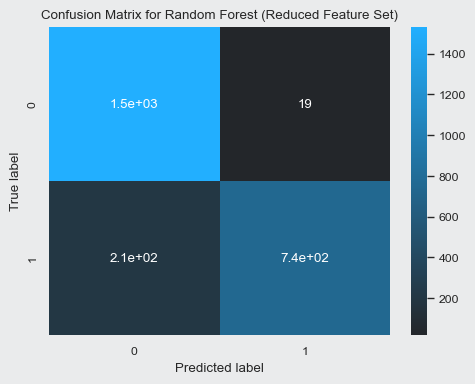

In [19]:
# Evaluate the process
rf_hpt_label_result = evaluate_hpt(
    model=rf_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, rf_hpt_label_result.predictions, 'Random Forest (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	100
Best Score:
	0.986980

-- Testing Results --
Accuracy    on Verification Data:	0.910000
Fbeta scroe on Verification Data:	0.784687

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.78      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 206 (21.684% out of 950 true positives, 8.240% overall)



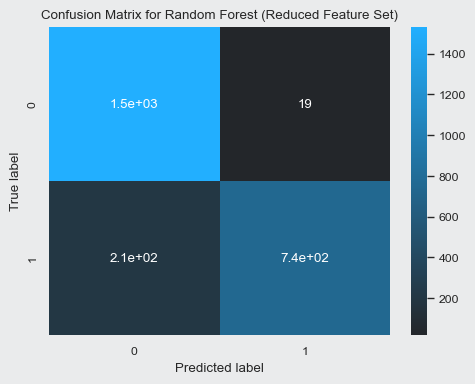

In [20]:
# Evaluate the process
rf_hpt_label_scaled_result = evaluate_hpt(
    model=rf_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, rf_hpt_label_scaled_result.predictions, 'Random Forest (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	10
	n_estimators:	20
Best Score:
	0.986996

-- Testing Results --
Accuracy    on Verification Data:	0.912000
Fbeta scroe on Verification Data:	0.789919

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.79      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 201 (21.158% out of 950 true positives, 8.040% overall)



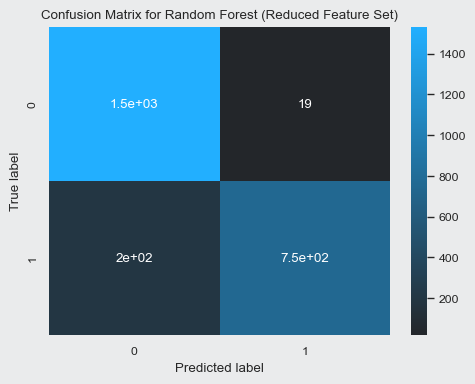

In [21]:
# Evaluate the process
rf_hpt_1hot_result = evaluate_hpt(
    model=rf_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, rf_hpt_1hot_result.predictions, 'Random Forest (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	10
	n_estimators:	20
Best Score:
	0.986996

-- Testing Results --
Accuracy    on Verification Data:	0.912000
Fbeta scroe on Verification Data:	0.789919

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.79      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 201 (21.158% out of 950 true positives, 8.040% overall)



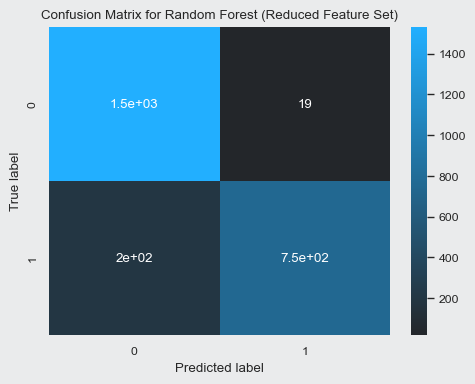

In [22]:
# Evaluate the process
rf_hpt_1hot_scaled_result = evaluate_hpt(
    model=rf_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, rf_hpt_1hot_scaled_result.predictions, 'Random Forest (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [23]:
best_random_forest_label = rf_model_label.best_estimator_
best_random_forest_label_scaled = rf_model_label_scaled.best_estimator_
best_random_forest_1hot = rf_model_1hot.best_estimator_
best_random_forest_1hot_scaled = rf_model_1hot_scaled.best_estimator_

In [24]:
%time _ = best_random_forest_label.fit(X_training_label, y_training)

CPU times: user 1min 41s, sys: 2.11 s, total: 1min 43s
Wall time: 14.9 s


In [25]:
%time _ = best_random_forest_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 1min 42s, sys: 2.02 s, total: 1min 44s
Wall time: 14.4 s


In [26]:
%time _ = best_random_forest_1hot.fit(X_training_1hot, y_training)

CPU times: user 13.5 s, sys: 718 ms, total: 14.2 s
Wall time: 3.01 s


In [27]:
%time _ = best_random_forest_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 13.1 s, sys: 641 ms, total: 13.7 s
Wall time: 2.51 s



-- Testing Results --
Accuracy    on Verification Data:	0.927676
Fbeta scroe on Verification Data:	0.820677

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5309 (18.071% out of 29378 true positives, 6.869% overall)



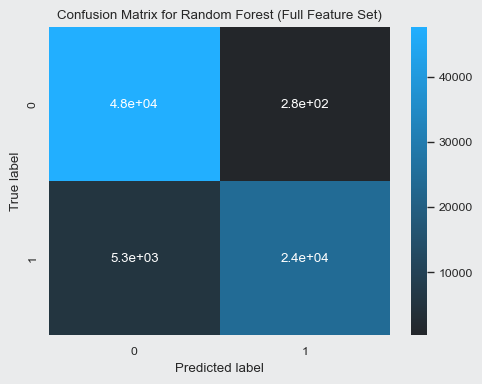

In [28]:
# Evaluate this model
rf_model_label_result = evaluate_model(
    model=best_random_forest_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_label_result.predictions, "Random Forest (Full Feature Set)")

In [29]:
# Compare with respective prototype model
_ = compare_models(rf_model_label_result, rf_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.035990 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.017676 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820677



-- Testing Results --
Accuracy    on Verification Data:	0.927754
Fbeta scroe on Verification Data:	0.820880

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5303 (18.051% out of 29378 true positives, 6.861% overall)



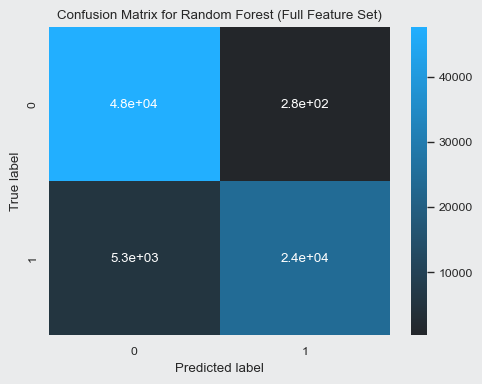

In [30]:
# Evaluate this model
rf_model_label_scaled_result = evaluate_model(
    model=best_random_forest_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_label_scaled_result.predictions, "Random Forest (Full Feature Set)")

In [31]:
# Compare with respective prototype model
_ = compare_models(rf_model_label_scaled_result, rf_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.036193 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.017754 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820880



-- Testing Results --
Accuracy    on Verification Data:	0.923096
Fbeta scroe on Verification Data:	0.807563

              precision    recall  f1-score   support

       False       0.89      0.99      0.94     47913
        True       0.99      0.81      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.94      0.90      0.91     77291
weighted avg       0.93      0.92      0.92     77291

False negatives: 5697 (19.392% out of 29378 true positives, 7.371% overall)



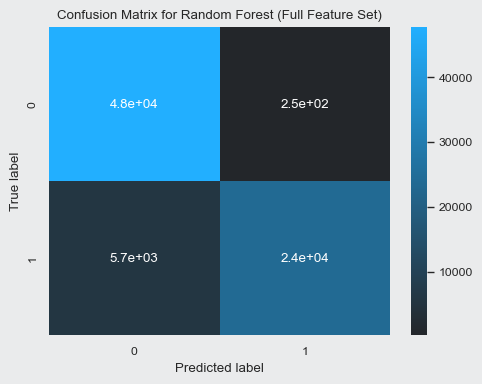

In [32]:
# Evaluate this model
rf_model_1hot_result = evaluate_model(
    model=best_random_forest_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_1hot_result.predictions, "Random Forest (Full Feature Set)")

In [33]:
# Compare with respective prototype model
_ = compare_models(rf_model_1hot_result, rf_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.017643 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011096 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563



-- Testing Results --
Accuracy    on Verification Data:	0.923096
Fbeta scroe on Verification Data:	0.807563

              precision    recall  f1-score   support

       False       0.89      0.99      0.94     47913
        True       0.99      0.81      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.94      0.90      0.91     77291
weighted avg       0.93      0.92      0.92     77291

False negatives: 5697 (19.392% out of 29378 true positives, 7.371% overall)



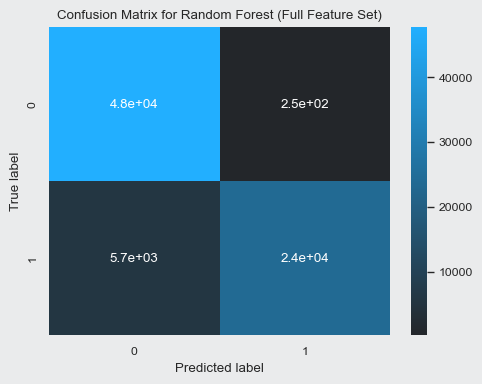

In [34]:
# Evaluate this model
rf_model_1hot_scaled_result = evaluate_model(
    model=best_random_forest_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_1hot_scaled_result.predictions, "Random Forest (Full Feature Set)")

In [35]:
# Compare with respective prototype model
_ = compare_models(rf_model_1hot_scaled_result, rf_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.017643 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011096 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563


In [36]:
# Compare HPT results with each other
print('\tRandom Forest: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(rf_hpt_label_result, rf_hpt_label_scaled_result)

print('\n\n\tRandom Forest: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(rf_hpt_1hot_result, rf_hpt_1hot_scaled_result)

	Random Forest: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its score: 0.784687


	Random Forest: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
Its score: 0.789919


In [37]:
print('\tRandom Forest: Label Encoded VS One-hot Encoded')
_ = compare_models(rf_hpt_label_result, rf_hpt_1hot_result)

print('\n\n\tRandom Forest: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(rf_hpt_label_scaled_result, rf_hpt_1hot_scaled_result)

	Random Forest: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.005232 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.002000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
Its score: 0.789919


	Random Forest: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.005232 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.002000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
Its score: 0.789919


In [38]:
BEST_HPT_SUB_RESULT = rf_hpt_label_result
BEST_SCALED_HPT_SUB_RESULT = rf_hpt_label_scaled_result

In [39]:
# Compare full models with each other
print('\tRandom Forest: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(rf_model_label_result, rf_model_label_scaled_result)

print('\n\n\tRandom Forest: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(rf_model_1hot_result, rf_model_1hot_scaled_result)

	Random Forest: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.000203 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000078 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820880


	Random Forest: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563


In [40]:
print('\tRandom Forest: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(rf_model_label_result, rf_model_1hot_result)

print('\n\n\tRandom Forest: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(rf_model_label_scaled_result, rf_model_1hot_scaled_result)

	Random Forest: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.013115 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004580 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820677


	Random Forest: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.013317 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004658 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820880


In [41]:
BEST_HPT_RESULT = rf_model_1hot_result
BEST_SCALED_HPT_RESULT = rf_model_1hot_scaled_result

In [42]:
# Store the model results
add_unscaled_model('Random Forest', rf_model_label_result, label_encoded=True)
add_unscaled_model('Random Forest', rf_model_1hot_result, label_encoded=False)
add_scaled_model('Random Forest', rf_model_label_scaled_result, label_encoded=True)
add_scaled_model('Random Forest', rf_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## K Nearest Neighbors

Our next candidate is KNN.
This model significantly benefits from our undersampling approach, as its computation time drastically increases with the data complexity.
The process we follow is the exact same as for the random forest approach:

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn = KNeighborsClassifier(n_jobs=-1)                                   # base estimator
knn_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'n_neighbors':  [5, 10, 20, 100, 150],
    'weights':      ['uniform', 'distance'],
}

In [45]:
knn_model_label = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
knn_model_label_scaled = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
knn_model_1hot = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
knn_model_1hot_scaled = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [46]:
%time _ = knn_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 837 ms, sys: 92.5 ms, total: 930 ms
Wall time: 1.09 s


In [47]:
%time _ = knn_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 820 ms, sys: 80 ms, total: 900 ms
Wall time: 1.06 s


In [48]:
%time _ = knn_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 5.26 s, sys: 1.13 s, total: 6.4 s
Wall time: 1.12 s


In [49]:
%time _ = knn_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 3.35 s, sys: 1.13 s, total: 4.49 s
Wall time: 620 ms


-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	distance
Best Score:
	0.952647

-- Testing Results --
Accuracy    on Verification Data:	0.898400
Fbeta scroe on Verification Data:	0.763681

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      1550
        True       0.96      0.76      0.85       950

    accuracy                           0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.91      0.90      0.90      2500

False negatives: 226 (23.789% out of 950 true positives, 9.040% overall)



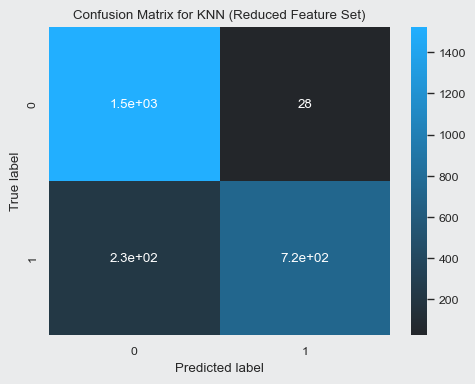

In [50]:
# Evaluate the process
knn_hpt_label_result = evaluate_hpt(
    model=knn_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, knn_hpt_label_result.predictions, 'KNN (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	distance
Best Score:
	0.952647

-- Testing Results --
Accuracy    on Verification Data:	0.898400
Fbeta scroe on Verification Data:	0.763681

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      1550
        True       0.96      0.76      0.85       950

    accuracy                           0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.91      0.90      0.90      2500

False negatives: 226 (23.789% out of 950 true positives, 9.040% overall)



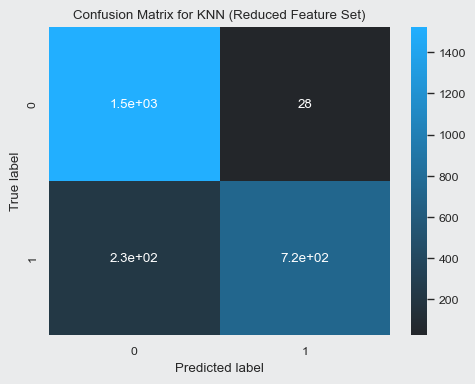

In [51]:
# Evaluate the process
knn_hpt_label_scaled_result = evaluate_hpt(
    model=knn_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, knn_hpt_label_scaled_result.predictions, 'KNN (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	n_neighbors:	10
	weights:	distance
Best Score:
	0.949460

-- Testing Results --
Accuracy    on Verification Data:	0.895200
Fbeta scroe on Verification Data:	0.754267

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      1550
        True       0.96      0.75      0.85       950

    accuracy                           0.90      2500
   macro avg       0.91      0.87      0.88      2500
weighted avg       0.90      0.90      0.89      2500

False negatives: 235 (24.737% out of 950 true positives, 9.400% overall)



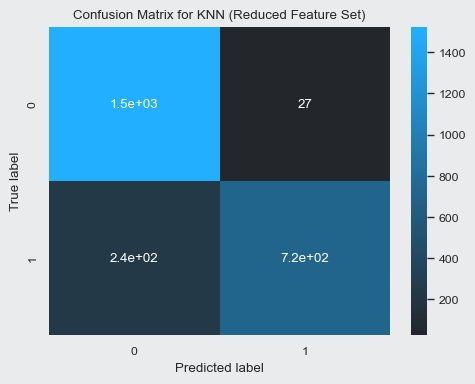

In [52]:
# Evaluate the process
knn_hpt_1hot_result = evaluate_hpt(
    model=knn_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, knn_hpt_1hot_result.predictions, 'KNN (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	n_neighbors:	10
	weights:	distance
Best Score:
	0.949460

-- Testing Results --
Accuracy    on Verification Data:	0.895200
Fbeta scroe on Verification Data:	0.754267

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      1550
        True       0.96      0.75      0.85       950

    accuracy                           0.90      2500
   macro avg       0.91      0.87      0.88      2500
weighted avg       0.90      0.90      0.89      2500

False negatives: 235 (24.737% out of 950 true positives, 9.400% overall)



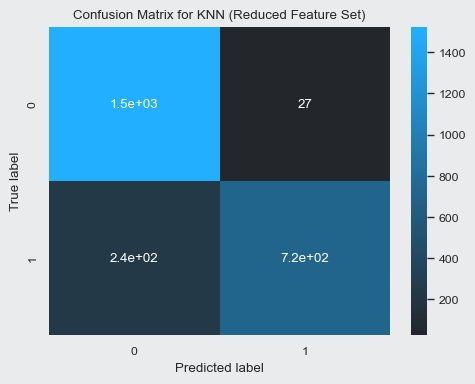

In [53]:
# Evaluate the process
knn_hpt_1hot_scaled_result = evaluate_hpt(
    model=knn_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, knn_hpt_1hot_scaled_result.predictions, 'KNN (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [54]:
best_knn_label = knn_model_label.best_estimator_
best_knn_label_scaled = knn_model_label_scaled.best_estimator_
best_knn_1hot = knn_model_1hot.best_estimator_
best_knn_1hot_scaled = knn_model_1hot_scaled.best_estimator_

In [55]:
%time _ = best_knn_label.fit(X_training_label, y_training)

CPU times: user 637 ms, sys: 405 ms, total: 1.04 s
Wall time: 380 ms


In [56]:
%time _ = best_knn_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 86.8 ms, sys: 162 ms, total: 248 ms
Wall time: 322 ms


In [57]:
%time _ = best_knn_1hot.fit(X_training_1hot, y_training)

CPU times: user 271 ms, sys: 773 ms, total: 1.04 s
Wall time: 1.93 s


In [58]:
%time _ = best_knn_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 258 ms, sys: 731 ms, total: 989 ms
Wall time: 1.49 s



-- Testing Results --
Accuracy    on Verification Data:	0.927741
Fbeta scroe on Verification Data:	0.823898

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.98      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5213 (17.745% out of 29378 true positives, 6.745% overall)



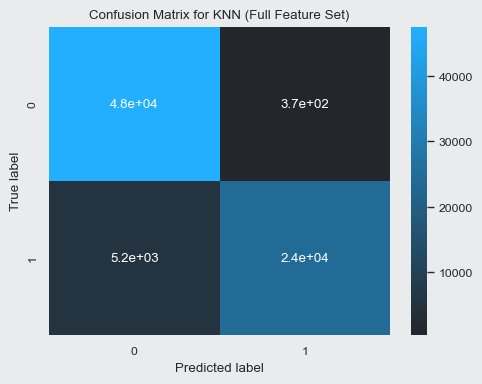

In [59]:
# Evaluate this model
knn_model_label_result = evaluate_model(
    model=best_knn_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_label_result.predictions, "KNN (Full Feature Set)")

In [60]:
# Compare with respective prototype model
_ = compare_models(knn_model_label_result, knn_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.060217 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.029341 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898



-- Testing Results --
Accuracy    on Verification Data:	0.934119
Fbeta scroe on Verification Data:	0.838656

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4777 (16.260% out of 29378 true positives, 6.181% overall)



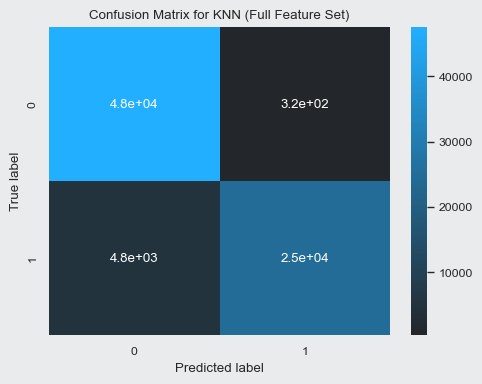

In [61]:
# Evaluate this model
knn_model_label_scaled_result = evaluate_model(
    model=best_knn_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_label_scaled_result.predictions, "KNN (Full Feature Set)")

In [62]:
# Compare with respective prototype model
_ = compare_models(knn_model_label_scaled_result, knn_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.074975 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.035719 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656



-- Testing Results --
Accuracy    on Verification Data:	0.926822
Fbeta scroe on Verification Data:	0.818646

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.82      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5369 (18.276% out of 29378 true positives, 6.946% overall)



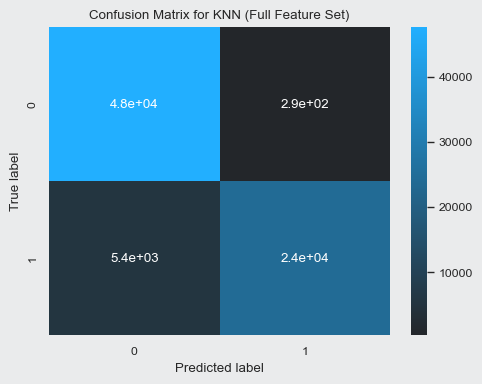

In [63]:
# Evaluate this model
knn_model_1hot_result = evaluate_model(
    model=best_knn_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_1hot_result.predictions, "KNN (Full Feature Set)")

In [64]:
# Compare with respective prototype model
_ = compare_models(knn_model_1hot_result, knn_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.064380 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.031622 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')
Its score: 0.818646



-- Testing Results --
Accuracy    on Verification Data:	0.926706
Fbeta scroe on Verification Data:	0.816698

              precision    recall  f1-score   support

       False       0.90      1.00      0.94     47913
        True       0.99      0.82      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5427 (18.473% out of 29378 true positives, 7.022% overall)



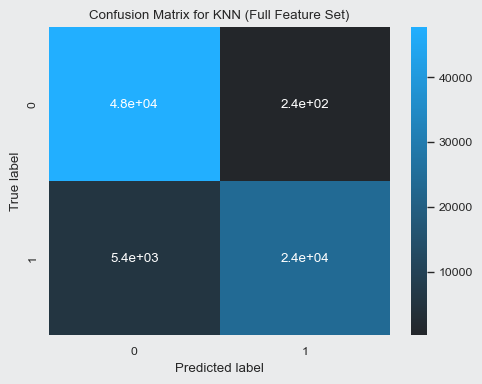

In [65]:
# Evaluate this model
knn_model_1hot_scaled_result = evaluate_model(
    model=best_knn_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_1hot_scaled_result.predictions, "KNN (Full Feature Set)")

In [66]:
# Compare with respective prototype model
_ = compare_models(knn_model_1hot_scaled_result, knn_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.062431 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.031506 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')
Its score: 0.816698


In [67]:
# Compare HPT results with each other
print('\tKNN: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(knn_hpt_label_result, knn_hpt_label_scaled_result)

print('\n\n\tKNN: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(knn_hpt_1hot_result, knn_hpt_1hot_scaled_result)

	KNN: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.763681


	KNN: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance') with Parameters
{'n_neighbors': 10, 'weights': 'distance'}
Its score: 0.754267


In [68]:
print('\tKNN: Label Encoded VS One-hot Encoded')
_ = compare_models(knn_hpt_label_result, knn_hpt_1hot_result)

print('\n\n\tKNN: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(knn_hpt_label_scaled_result, knn_hpt_1hot_scaled_result)

	KNN: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.009415 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003200 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.763681


	KNN: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.009415 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003200 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.763681


In [69]:
# Compare full models with each other
print('\tKNN: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(knn_model_label_result, knn_model_label_scaled_result)

print('\n\n\tKNN: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(knn_model_1hot_result, knn_model_1hot_scaled_result)

	KNN: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.014758 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006378 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656


	KNN: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.001948 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000116 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')
Its score: 0.818646


In [70]:
print('\tKNN: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(knn_model_label_result, knn_model_1hot_result)

print('\n\n\tKNN: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(knn_model_label_scaled_result, knn_model_1hot_scaled_result)

	KNN: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.005252 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000919 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898


	KNN: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.021958 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.007414 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656


In [71]:
# Compare new models with best so far in their respective category
_ = compare_models(knn_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(knn_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(knn_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(knn_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.021006 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.011600 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its score: 0.784687

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.030421 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.014800 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its score: 0.784687

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.021006 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.011600 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its sco

In [72]:
_ = compare_models(knn_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(knn_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(knn_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(knn_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.016336 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004645 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.011084 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003726 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')
Its score: 0.818646

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.031094 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011023 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.009135 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003610 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, n_neighbo

In [73]:
BEST_HPT_RESULT = knn_model_label_result
BEST_HPT_SCALED_RESULT = knn_model_label_scaled_result

In [74]:
# Track overall best model
_ = compare_models(knn_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(knn_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(knn_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(knn_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.003018 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.000013 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.017776 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.006366 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.002234 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000932 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404)
Its score: 0.820880

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.004182 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.001048 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, rando

In [75]:
# Store the model results
add_unscaled_model('KNN', knn_model_label_result, label_encoded=True)
add_unscaled_model('KNN', knn_model_1hot_result, label_encoded=False)
add_scaled_model('KNN', knn_model_label_scaled_result, label_encoded=True)
add_scaled_model('KNN', knn_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Naive Bayes

Our next candidate is Naive Bayes.
Now this model doesn't offer much in terms of hyperparameter tuning, but we want to include it anyways.

Again, the same procedure as before...

In [76]:
from sklearn.naive_bayes import GaussianNB

In [77]:
naive_bayes = GaussianNB()                                             # base estimator
rel_positive = y_true.value_counts(True).iloc[1]
nb_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'priors': [None, [1 - rel_positive, rel_positive]],
}

In [78]:
nb_model_label = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nb_model_label_scaled = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nb_model_1hot = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nb_model_1hot_scaled = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [79]:
%time _ = nb_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 99.7 ms, sys: 8.56 ms, total: 108 ms
Wall time: 75.1 ms


In [80]:
%time _ = nb_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 29.5 ms, sys: 1.29 ms, total: 30.8 ms
Wall time: 30 ms


In [81]:
%time _ = nb_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 41.8 ms, sys: 4.11 ms, total: 45.9 ms
Wall time: 82.4 ms


In [82]:
%time _ = nb_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 66 ms, sys: 5.12 ms, total: 71.2 ms
Wall time: 250 ms


-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.966831

-- Testing Results --
Accuracy    on Verification Data:	0.914800
Fbeta scroe on Verification Data:	0.807620

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      1550
        True       0.96      0.81      0.88       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 184 (19.368% out of 950 true positives, 7.360% overall)



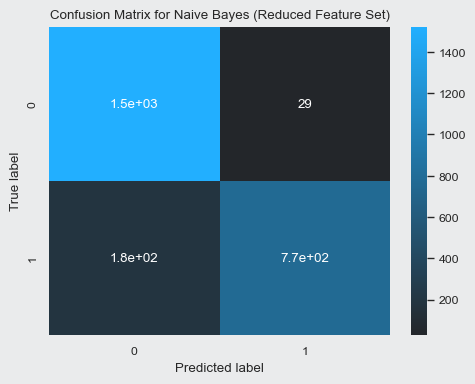

In [83]:
# Evaluate the process
nb_hpt_label_result = evaluate_hpt(
    model=nb_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, nb_hpt_label_result.predictions, 'Naive Bayes (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.966831

-- Testing Results --
Accuracy    on Verification Data:	0.914800
Fbeta scroe on Verification Data:	0.807620

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      1550
        True       0.96      0.81      0.88       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 184 (19.368% out of 950 true positives, 7.360% overall)



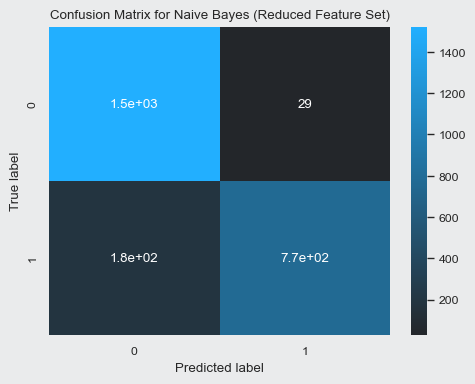

In [84]:
# Evaluate the process
nb_hpt_label_scaled_result = evaluate_hpt(
    model=nb_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, nb_hpt_label_scaled_result.predictions, 'Naive Bayes (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.969005

-- Testing Results --
Accuracy    on Verification Data:	0.922000
Fbeta scroe on Verification Data:	0.800508

              precision    recall  f1-score   support

       False       0.89      1.00      0.94      1550
        True       0.99      0.80      0.89       950

    accuracy                           0.92      2500
   macro avg       0.94      0.90      0.91      2500
weighted avg       0.93      0.92      0.92      2500

False negatives: 191 (20.105% out of 950 true positives, 7.640% overall)



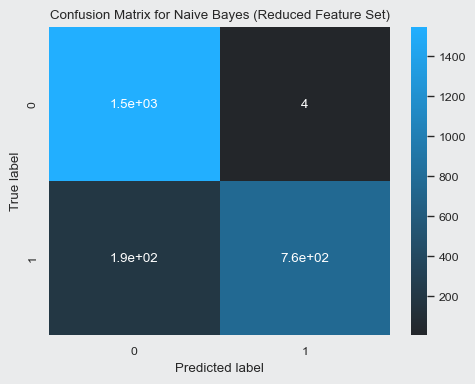

In [85]:
# Evaluate the process
nb_hpt_1hot_result = evaluate_hpt(
    model=nb_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, nb_hpt_1hot_result.predictions, 'Naive Bayes (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.969005

-- Testing Results --
Accuracy    on Verification Data:	0.922000
Fbeta scroe on Verification Data:	0.800508

              precision    recall  f1-score   support

       False       0.89      1.00      0.94      1550
        True       0.99      0.80      0.89       950

    accuracy                           0.92      2500
   macro avg       0.94      0.90      0.91      2500
weighted avg       0.93      0.92      0.92      2500

False negatives: 191 (20.105% out of 950 true positives, 7.640% overall)



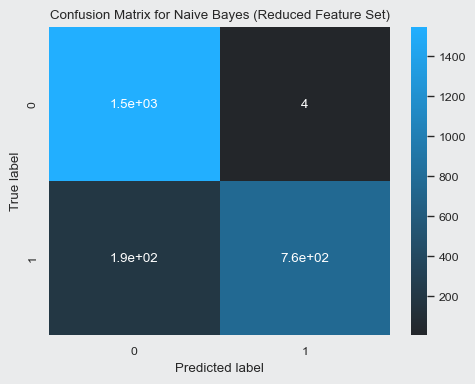

In [86]:
# Evaluate the process
nb_hpt_1hot_scaled_result = evaluate_hpt(
    model=nb_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, nb_hpt_1hot_scaled_result.predictions, 'Naive Bayes (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [87]:
best_nb_label = nb_model_label.best_estimator_
best_nb_label_scaled = nb_model_label_scaled.best_estimator_
best_nb_1hot = nb_model_1hot.best_estimator_
best_nb_1hot_scaled = nb_model_1hot_scaled.best_estimator_

In [88]:
%time _ = best_nb_label.fit(X_training_label, y_training)

CPU times: user 482 ms, sys: 285 ms, total: 768 ms
Wall time: 699 ms


In [89]:
%time _ = best_nb_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 239 ms, sys: 210 ms, total: 449 ms
Wall time: 496 ms


In [90]:
%time _ = best_nb_1hot.fit(X_training_1hot, y_training)

CPU times: user 646 ms, sys: 1.38 s, total: 2.02 s
Wall time: 2.58 s


In [91]:
%time _ = best_nb_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 653 ms, sys: 1.42 s, total: 2.07 s
Wall time: 2.94 s



-- Testing Results --
Accuracy    on Verification Data:	0.675020
Fbeta scroe on Verification Data:	0.163285

              precision    recall  f1-score   support

       False       0.66      0.99      0.79     47913
        True       0.91      0.16      0.27     29378

    accuracy                           0.68     77291
   macro avg       0.78      0.58      0.53     77291
weighted avg       0.75      0.68      0.59     77291

False negatives: 24620 (83.804% out of 29378 true positives, 31.854% overall)



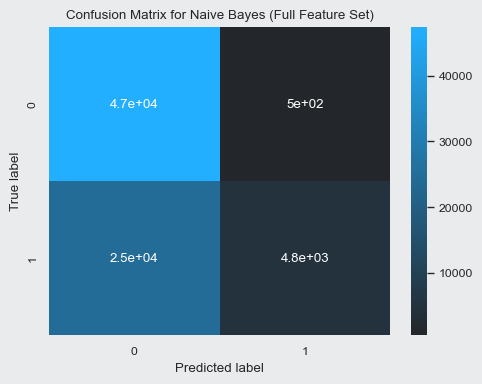

In [92]:
# Evaluate this model
nb_model_label_result = evaluate_model(
    model=best_nb_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_label_result.predictions, "Naive Bayes (Full Feature Set)")

In [93]:
# Compare with respective prototype model
_ = compare_models(nb_model_label_result, nb_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.644335 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.239780 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.807620



-- Testing Results --
Accuracy    on Verification Data:	0.926783
Fbeta scroe on Verification Data:	0.840574

              precision    recall  f1-score   support

       False       0.91      0.98      0.94     47913
        True       0.96      0.84      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 4715 (16.049% out of 29378 true positives, 6.100% overall)



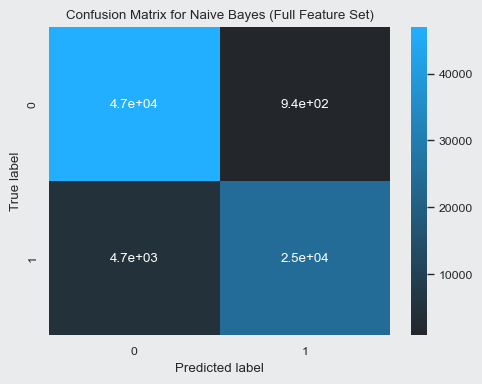

In [94]:
# Evaluate this model
nb_model_label_scaled_result = evaluate_model(
    model=best_nb_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_label_scaled_result.predictions, "Naive Bayes (Full Feature Set)")

In [95]:
# Compare with respective prototype model
_ = compare_models(nb_model_label_scaled_result, nb_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.032954 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011983 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.840574



-- Testing Results --
Accuracy    on Verification Data:	0.674141
Fbeta scroe on Verification Data:	0.160955

              precision    recall  f1-score   support

       False       0.66      0.99      0.79     47913
        True       0.90      0.16      0.27     29378

    accuracy                           0.67     77291
   macro avg       0.78      0.57      0.53     77291
weighted avg       0.75      0.67      0.59     77291

False negatives: 24688 (84.036% out of 29378 true positives, 31.942% overall)



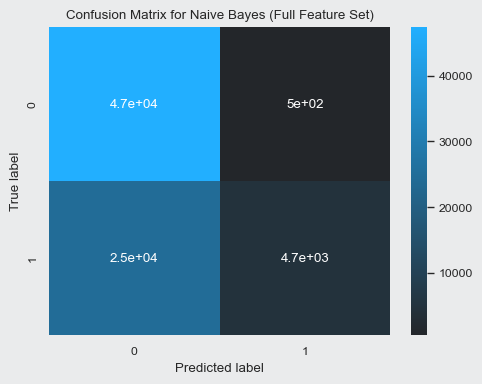

In [96]:
# Evaluate this model
nb_model_1hot_result = evaluate_model(
    model=best_nb_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_1hot_result.predictions, "Naive Bayes (Full Feature Set)")

In [97]:
# Compare with respective prototype model
_ = compare_models(nb_model_1hot_result, nb_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.639552 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.247859 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.800508



-- Testing Results --
Accuracy    on Verification Data:	0.944069
Fbeta scroe on Verification Data:	0.885575

              precision    recall  f1-score   support

       False       0.93      0.98      0.96     47913
        True       0.97      0.88      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.93      0.94     77291
weighted avg       0.95      0.94      0.94     77291

False negatives: 3383 (11.515% out of 29378 true positives, 4.377% overall)



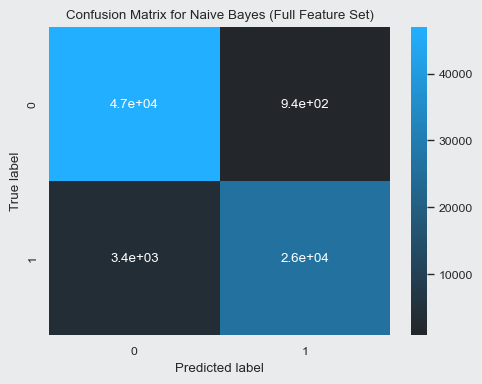

In [98]:
# Evaluate this model
nb_model_1hot_scaled_result = evaluate_model(
    model=best_nb_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_1hot_scaled_result.predictions, "Naive Bayes (Full Feature Set)")

In [99]:
# Compare with respective prototype model
_ = compare_models(nb_model_1hot_scaled_result, nb_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.085067 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.022069 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.885575


In [100]:
# Compare HPT results with each other
print('\tNaive Bayes: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(nb_hpt_label_result, nb_hpt_label_scaled_result)

print('\n\n\tNaive Bayes: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(nb_hpt_1hot_result, nb_hpt_1hot_scaled_result)

	Naive Bayes: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620


	Naive Bayes: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.800508


In [101]:
print('\tNaive Bayes: Label Encoded VS One-hot Encoded')
_ = compare_models(nb_hpt_label_result, nb_hpt_1hot_result)

print('\n\n\tNaive Bayes: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(nb_hpt_label_scaled_result, nb_hpt_1hot_scaled_result)

	Naive Bayes: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.007113 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.007200 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620


	Naive Bayes: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.007113 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.007200 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620


In [102]:
# Compare full models with each other
print('\tNaive Bayes: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(nb_model_label_result, nb_model_label_scaled_result)

print('\n\n\tNaive Bayes: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(nb_model_1hot_result, nb_model_1hot_scaled_result)

	Naive Bayes: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.677289 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.251763 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.840574


	Naive Bayes: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.724619 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.269928 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575


In [103]:
print('\tNaive Bayes: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(nb_model_label_result, nb_model_1hot_result)

print('\n\n\tNaive Bayes: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(nb_model_label_scaled_result, nb_model_1hot_scaled_result)

	Naive Bayes: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.002330 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000880 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.163285


	Naive Bayes: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.045001 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.017285 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575


In [104]:
# Compare new models with best so far in their respective category
_ = compare_models(nb_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(nb_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(nb_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(nb_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.022933 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004800 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.015820 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.012000 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.800508

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.022933 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004800 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.015820 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.012000 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.800508


In [105]:
BEST_HPT_SUB_RESULT = nb_hpt_label_result
BEST_HPT_SUB_SCALED_RESULT = nb_hpt_label_scaled_result

In [106]:
_ = compare_models(nb_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(nb_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(nb_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(nb_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.660613 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.252720 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.662943 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.253600 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.033011 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003687 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.840574

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.078012 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.020973 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.885575


In [107]:
BEST_HPT_SCALED_RESULT = nb_model_1hot_scaled_result

In [108]:
# Track overall best model
_ = compare_models(nb_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(nb_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(nb_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(nb_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.675371 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.259099 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.001918 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.007336 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.840574

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.677701 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.259979 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.838656

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.046918 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.009949 --> Improvement!

Best model so far:
GaussianNB()
Its score: 0.885575


In [109]:
# Store the model results
add_unscaled_model('Naive Bayes', nb_model_label_result, label_encoded=True)
add_unscaled_model('Naive Bayes', nb_model_1hot_result, label_encoded=False)
add_scaled_model('Naive Bayes', nb_model_label_scaled_result, label_encoded=True)
add_scaled_model('Naive Bayes', nb_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
logistic_regression = LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)   # base estimator
lr_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5, 1.e-6],
    'C': [.4+.2*n for n in range(6)],
    'fit_intercept': [True, False],
}

In [112]:
lr_model_label = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
lr_model_label_scaled = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
lr_model_1hot = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
lr_model_1hot_scaled = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [113]:
%time _ = lr_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 1.12 s, sys: 160 ms, total: 1.28 s
Wall time: 46 s


In [114]:
%time _ = lr_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 1.09 s, sys: 93.7 ms, total: 1.18 s
Wall time: 41.4 s


In [115]:
%time _ = lr_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 4min 48s, sys: 30.5 s, total: 5min 19s
Wall time: 1min 29s


In [116]:
%time _ = lr_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 4min 54s, sys: 25.8 s, total: 5min 20s
Wall time: 1min 30s


-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	penalty:	None
	tol:	0.0001
Best Score:
	0.967306

-- Testing Results --
Accuracy    on Verification Data:	0.914800
Fbeta scroe on Verification Data:	0.796206

              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1550
        True       0.98      0.79      0.88       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 195 (20.526% out of 950 true positives, 7.800% overall)



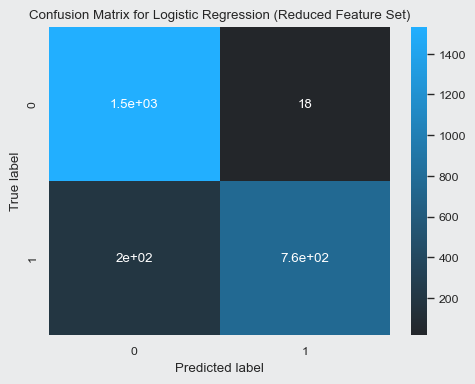

In [117]:
# Evaluate the process
lr_hpt_label_result = evaluate_hpt(
    model=lr_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, lr_hpt_label_result.predictions, 'Logistic Regression (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	penalty:	None
	tol:	0.0001
Best Score:
	0.967306

-- Testing Results --
Accuracy    on Verification Data:	0.914800
Fbeta scroe on Verification Data:	0.796206

              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1550
        True       0.98      0.79      0.88       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 195 (20.526% out of 950 true positives, 7.800% overall)



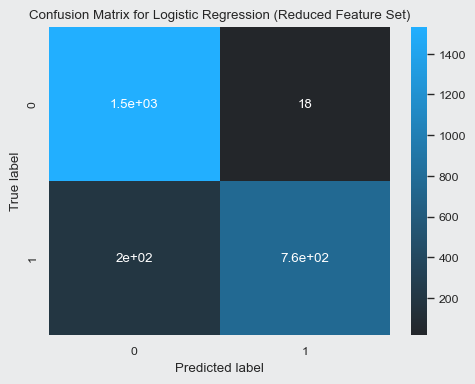

In [118]:
# Evaluate the process
lr_hpt_label_scaled_result = evaluate_hpt(
    model=lr_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, lr_hpt_label_scaled_result.predictions, 'Logistic Regression (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	1.0
	fit_intercept:	True
	penalty:	l2
	tol:	0.0001
Best Score:
	0.983747

-- Testing Results --
Accuracy    on Verification Data:	0.906000
Fbeta scroe on Verification Data:	0.779414

              precision    recall  f1-score   support

       False       0.88      0.98      0.93      1550
        True       0.97      0.78      0.86       950

    accuracy                           0.91      2500
   macro avg       0.92      0.88      0.90      2500
weighted avg       0.91      0.91      0.90      2500

False negatives: 211 (22.211% out of 950 true positives, 8.440% overall)



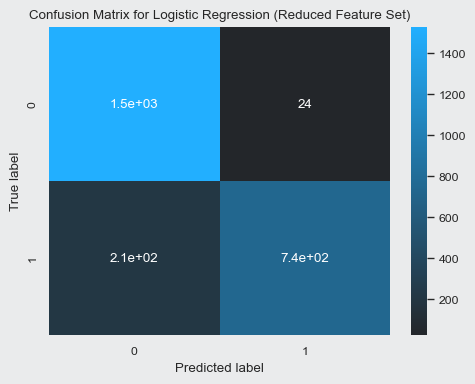

In [119]:
# Evaluate the process
lr_hpt_1hot_result = evaluate_hpt(
    model=lr_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, lr_hpt_1hot_result.predictions, 'Logistic Regression (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	1.0
	fit_intercept:	True
	penalty:	l2
	tol:	0.0001
Best Score:
	0.983747

-- Testing Results --
Accuracy    on Verification Data:	0.906000
Fbeta scroe on Verification Data:	0.779414

              precision    recall  f1-score   support

       False       0.88      0.98      0.93      1550
        True       0.97      0.78      0.86       950

    accuracy                           0.91      2500
   macro avg       0.92      0.88      0.90      2500
weighted avg       0.91      0.91      0.90      2500

False negatives: 211 (22.211% out of 950 true positives, 8.440% overall)



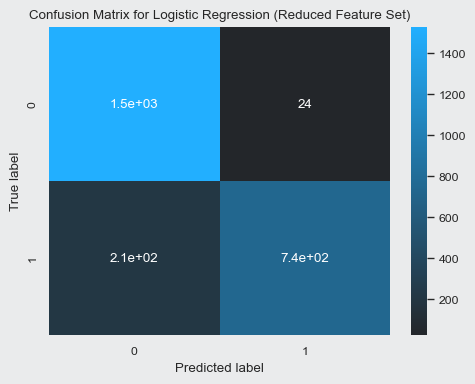

In [120]:
# Evaluate the process
lr_hpt_1hot_scaled_result = evaluate_hpt(
    model=lr_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, lr_hpt_1hot_scaled_result.predictions, 'Logistic Regression (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [121]:
best_lr_label = lr_model_label.best_estimator_
best_lr_label_scaled = lr_model_label_scaled.best_estimator_
best_lr_1hot = lr_model_1hot.best_estimator_
best_lr_1hot_scaled = lr_model_1hot_scaled.best_estimator_

In [122]:
%time _ = best_lr_label.fit(X_training_label, y_training)

CPU times: user 1.25 s, sys: 493 ms, total: 1.74 s
Wall time: 8min 6s


In [123]:
%time _ = best_lr_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 468 ms, sys: 565 ms, total: 1.03 s
Wall time: 5min 45s


In [124]:
%time _ = best_lr_1hot.fit(X_training_1hot, y_training)

CPU times: user 1.83 s, sys: 2.2 s, total: 4.03 s
Wall time: 20min 6s


In [125]:
%time _ = best_lr_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 1.03 s, sys: 1.57 s, total: 2.6 s
Wall time: 8min 46s



-- Testing Results --
Accuracy    on Verification Data:	0.907842
Fbeta scroe on Verification Data:	0.783985

              precision    recall  f1-score   support

       False       0.88      0.98      0.93     47913
        True       0.97      0.78      0.87     29378

    accuracy                           0.91     77291
   macro avg       0.92      0.88      0.90     77291
weighted avg       0.91      0.91      0.91     77291

False negatives: 6390 (21.751% out of 29378 true positives, 8.267% overall)



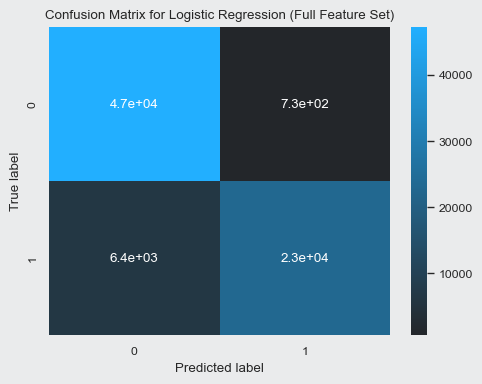

In [126]:
# Evaluate this model
lr_model_label_result = evaluate_model(
    model=best_lr_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_label_result.predictions, "Logistic Regression (Full Feature Set)")

In [127]:
# Compare with respective prototype model
_ = compare_models(lr_model_label_result, lr_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.012221 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006958 --> Worsened!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404)
Its score: 0.796206



-- Testing Results --
Accuracy    on Verification Data:	0.914026
Fbeta scroe on Verification Data:	0.798010

              precision    recall  f1-score   support

       False       0.89      0.99      0.93     47913
        True       0.97      0.80      0.88     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.90     77291
weighted avg       0.92      0.91      0.91     77291

False negatives: 5976 (20.342% out of 29378 true positives, 7.732% overall)



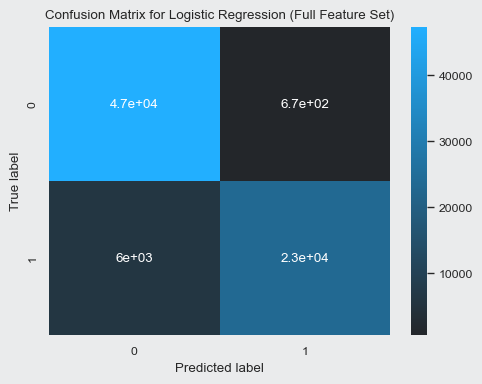

In [128]:
# Evaluate this model
lr_model_label_scaled_result = evaluate_model(
    model=best_lr_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_label_scaled_result.predictions, "Logistic Regression (Full Feature Set)")

In [129]:
# Compare with respective prototype model
_ = compare_models(lr_model_label_scaled_result, lr_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.001804 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.000774 --> Worsened!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404)
Its score: 0.798010



-- Testing Results --
Accuracy    on Verification Data:	0.918684
Fbeta scroe on Verification Data:	0.811462

              precision    recall  f1-score   support

       False       0.89      0.99      0.94     47913
        True       0.97      0.81      0.88     29378

    accuracy                           0.92     77291
   macro avg       0.93      0.90      0.91     77291
weighted avg       0.92      0.92      0.92     77291

False negatives: 5578 (18.987% out of 29378 true positives, 7.217% overall)



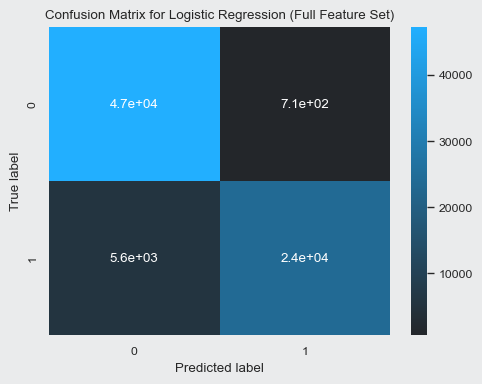

In [130]:
# Evaluate this model
lr_model_1hot_result = evaluate_model(
    model=best_lr_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_1hot_result.predictions, "Logistic Regression (Full Feature Set)")

In [131]:
# Compare with respective prototype model
_ = compare_models(lr_model_1hot_result, lr_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.032048 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.012684 --> Improvement!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)
Its score: 0.811462



-- Testing Results --
Accuracy    on Verification Data:	0.919784
Fbeta scroe on Verification Data:	0.818932

              precision    recall  f1-score   support

       False       0.90      0.98      0.94     47913
        True       0.97      0.82      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.93      0.90      0.91     77291
weighted avg       0.92      0.92      0.92     77291

False negatives: 5356 (18.231% out of 29378 true positives, 6.930% overall)



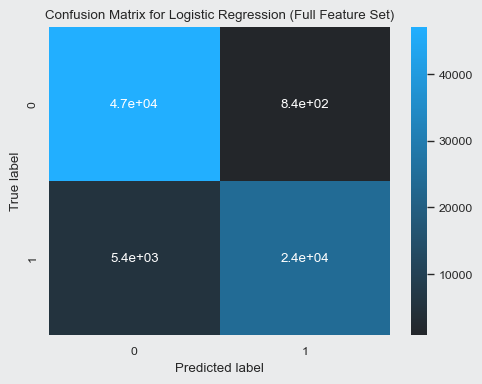

In [132]:
# Evaluate this model
lr_model_1hot_scaled_result = evaluate_model(
    model=best_lr_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_1hot_scaled_result.predictions, "Logistic Regression (Full Feature Set)")

In [133]:
# Compare with respective prototype model
_ = compare_models(lr_model_1hot_scaled_result, lr_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.039518 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.013784 --> Improvement!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)
Its score: 0.818932


In [134]:
# Compare HPT results with each other
print('\tLogistic Regression: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(lr_hpt_label_result, lr_hpt_label_scaled_result)

print('\n\n\tLogistic Regression: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(lr_hpt_1hot_result, lr_hpt_1hot_scaled_result)

	Logistic Regression: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404) with Parameters
{'C': 0.4, 'fit_intercept': True, 'penalty': None, 'tol': 0.0001}
Its score: 0.796206


	Logistic Regression: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404) with Parameters
{'C': 1.0, 'fit_intercept': True, 'penalty': 'l2', 'tol': 0.0001}
Its score: 0.779414


In [135]:
print('\tLogistic Regression: Label Encoded VS One-hot Encoded')
_ = compare_models(lr_hpt_label_result, lr_hpt_1hot_result)

print('\n\n\tLogistic Regression: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(lr_hpt_label_scaled_result, lr_hpt_1hot_scaled_result)

	Logistic Regression: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.016792 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008800 --> Improvement!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404) with Parameters
{'C': 0.4, 'fit_intercept': True, 'penalty': None, 'tol': 0.0001}
Its score: 0.796206


	Logistic Regression: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.016792 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008800 --> Improvement!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404) with Parameters
{'C': 0.4, 'fit_intercept': True, 'penalty': None, 'tol': 0.0001}
Its score: 0.796206


In [136]:
# Compare full models with each other
print('\tLogistic Regression: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(lr_model_label_result, lr_model_label_scaled_result)

print('\n\n\tLogistic Regression: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(lr_model_1hot_result, lr_model_1hot_scaled_result)

	Logistic Regression: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.014025 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006184 --> Worsened!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404)
Its score: 0.798010


	Logistic Regression: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.007470 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.001100 --> Worsened!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)
Its score: 0.818932


In [137]:
print('\tLogistic Regression: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(lr_model_label_result, lr_model_1hot_result)

print('\n\n\tLogistic Regression: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(lr_model_label_scaled_result, lr_model_1hot_scaled_result)

	Logistic Regression: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.027477 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.010842 --> Worsened!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)
Its score: 0.811462


	Logistic Regression: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.020922 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.005757 --> Worsened!

Best model so far:
LogisticRegression(max_iter=30000, n_jobs=-1, random_state=404)
Its score: 0.818932


In [138]:
# Compare new models with best so far in their respective category
_ = compare_models(lr_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(lr_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(lr_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(lr_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.011415 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.028207 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.008800 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.011518 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.004800 --> Improvement!

Best model so far:
LogisticRegression(C=0.4, max_iter=30000, n_jobs=-1, penalty=None,
                   random_state=404) with Parameters
{'C': 0.4, 'fit_intercept': True, 'penalty': None, 'tol': 0.0001}
Its score: 0.796206

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.005273 --> Worsened!
new_results.accuracy - old_results.accuracy = 

In [139]:
BEST_HPT_SUB_SCALED_RESULT = lr_hpt_label_scaled_result

In [140]:
_ = compare_models(lr_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(lr_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(lr_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(lr_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.039914 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.019899 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.012436 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.009057 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.823898

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.009553 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.009070 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.011369 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.003312 --> Worsened!

Best model so far:
LogisticRegressio

In [141]:
BEST_HPT_SCALED_RESULT = lr_model_1hot_scaled_result

In [142]:
# Track overall best model
_ = compare_models(lr_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(lr_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(lr_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(lr_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.101590 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.036227 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.087565 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.030042 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.074113 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.025385 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.066643 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.024285 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575


In [143]:
# Store the model results
add_unscaled_model('Logistic Regression', lr_model_label_result, label_encoded=True)
add_unscaled_model('Logistic Regression', lr_model_1hot_result, label_encoded=False)
add_scaled_model('Logistic Regression', lr_model_label_scaled_result, label_encoded=True)
add_scaled_model('Logistic Regression', lr_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Support Vector Machine

In [144]:
from sklearn.svm import SVC

In [145]:
svc = SVC(max_iter=15000, random_state=404)                                             # base estimator
svc_param_grid = {                                                                      # parameter grid for hyperparameter tuning
    'C': [.4+.2*n for n in range(6)],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 5, 10, 15],
    'tol': [1.e-4, 1.e-5, 1.e-6],
}

In [146]:
svc_model_label = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
svc_model_label_scaled = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
svc_model_1hot = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
svc_model_1hot_scaled = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [147]:
%time _ = svc_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 40.5 s, sys: 292 ms, total: 40.8 s
Wall time: 42 s


In [148]:
%time _ = svc_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 40.8 s, sys: 275 ms, total: 41.1 s
Wall time: 42.3 s


In [149]:
%time _ = svc_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 38.1 s, sys: 235 ms, total: 38.3 s
Wall time: 39.5 s


In [150]:
%time _ = svc_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 34.8 s, sys: 201 ms, total: 35 s
Wall time: 35.8 s


-- Training Results --
Best Parameters:
	C:	0.4
	degree:	3
	kernel:	linear
	tol:	0.0001
Best Score:
	0.954403

-- Testing Results --
Accuracy    on Verification Data:	0.110400
Fbeta scroe on Verification Data:	0.154789

              precision    recall  f1-score   support

       False       0.14      0.08      0.10      1550
        True       0.09      0.16      0.12       950

    accuracy                           0.11      2500
   macro avg       0.12      0.12      0.11      2500
weighted avg       0.12      0.11      0.11      2500

False negatives: 802 (84.421% out of 950 true positives, 32.080% overall)



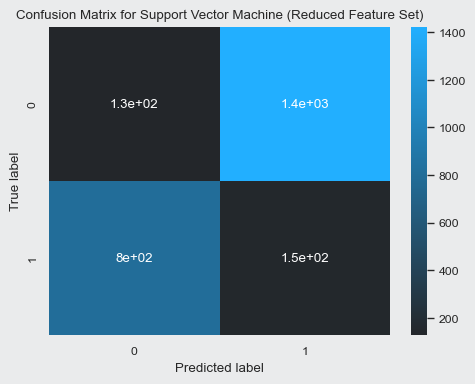

In [151]:
# Evaluate the process
svc_hpt_label_result = evaluate_hpt(
    model=svc_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, svc_hpt_label_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	0.4
	degree:	3
	kernel:	linear
	tol:	0.0001
Best Score:
	0.954403

-- Testing Results --
Accuracy    on Verification Data:	0.110400
Fbeta scroe on Verification Data:	0.154789

              precision    recall  f1-score   support

       False       0.14      0.08      0.10      1550
        True       0.09      0.16      0.12       950

    accuracy                           0.11      2500
   macro avg       0.12      0.12      0.11      2500
weighted avg       0.12      0.11      0.11      2500

False negatives: 802 (84.421% out of 950 true positives, 32.080% overall)



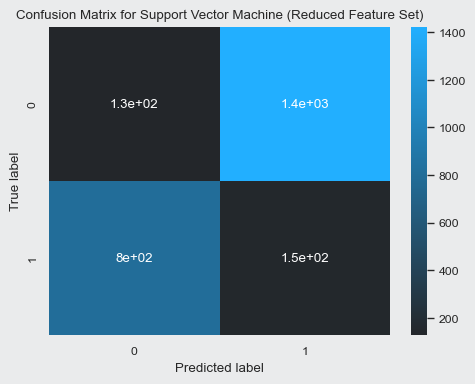

In [152]:
# Evaluate the process
svc_hpt_label_scaled_result = evaluate_hpt(
    model=svc_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, svc_hpt_label_scaled_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	1.4
	degree:	3
	kernel:	linear
	tol:	0.0001
Best Score:
	0.973561

-- Testing Results --
Accuracy    on Verification Data:	0.912000
Fbeta scroe on Verification Data:	0.799261

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      1550
        True       0.96      0.80      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 192 (20.211% out of 950 true positives, 7.680% overall)



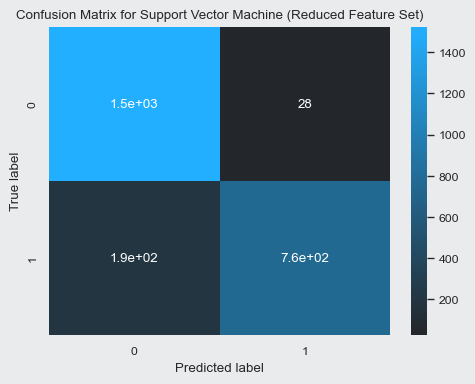

In [153]:
# Evaluate the process
svc_hpt_1hot_result = evaluate_hpt(
    model=svc_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, svc_hpt_1hot_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	C:	1.4
	degree:	3
	kernel:	linear
	tol:	0.0001
Best Score:
	0.973561

-- Testing Results --
Accuracy    on Verification Data:	0.912000
Fbeta scroe on Verification Data:	0.799261

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      1550
        True       0.96      0.80      0.87       950

    accuracy                           0.91      2500
   macro avg       0.93      0.89      0.90      2500
weighted avg       0.92      0.91      0.91      2500

False negatives: 192 (20.211% out of 950 true positives, 7.680% overall)



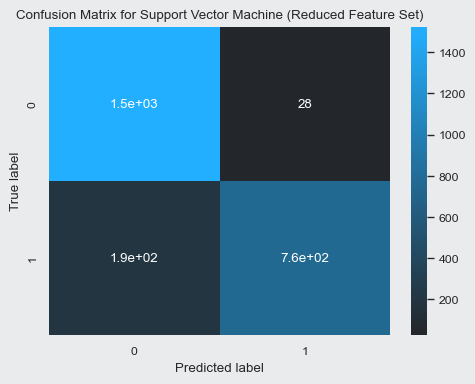

In [154]:
# Evaluate the process
svc_hpt_1hot_scaled_result = evaluate_hpt(
    model=svc_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, svc_hpt_1hot_scaled_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [155]:
best_svc_label = svc_model_label.best_estimator_
best_svc_label_scaled = svc_model_label_scaled.best_estimator_
best_svc_1hot = svc_model_1hot.best_estimator_
best_svc_1hot_scaled = svc_model_1hot_scaled.best_estimator_

In [156]:
%time _ = best_svc_label.fit(X_training_label, y_training)

CPU times: user 39.7 s, sys: 686 ms, total: 40.4 s
Wall time: 40.9 s


In [157]:
%time _ = best_svc_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 8min 39s, sys: 20.4 s, total: 8min 59s
Wall time: 9min 16s


In [158]:
%time _ = best_svc_1hot.fit(X_training_1hot, y_training)

CPU times: user 4min 35s, sys: 18.4 s, total: 4min 54s
Wall time: 5min 10s


In [159]:
%time _ = best_svc_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 8min 9s, sys: 31.7 s, total: 8min 41s
Wall time: 9min 5s



-- Testing Results --
Accuracy    on Verification Data:	0.856258
Fbeta scroe on Verification Data:	0.923827

              precision    recall  f1-score   support

       False       0.95      0.81      0.88     47913
        True       0.75      0.93      0.83     29378

    accuracy                           0.86     77291
   macro avg       0.85      0.87      0.85     77291
weighted avg       0.87      0.86      0.86     77291

False negatives: 2176 (7.407% out of 29378 true positives, 2.815% overall)



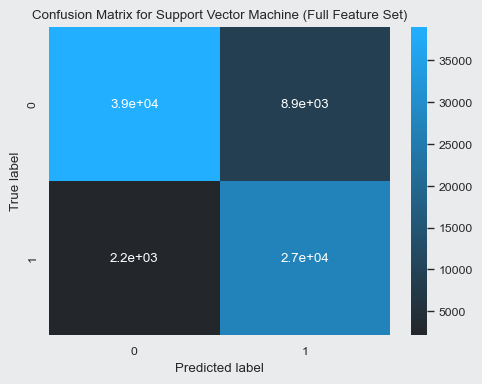

In [160]:
# Evaluate this model
svc_model_label_result = evaluate_model(
    model=best_svc_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_label_result.predictions, "Support Vector Machine (Full Feature Set)")

In [161]:
# Compare with respective prototype model
_ = compare_models(svc_model_label_result, svc_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.769038 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.745858 --> Improvement!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.923827



-- Testing Results --
Accuracy    on Verification Data:	0.752248
Fbeta scroe on Verification Data:	0.379010

              precision    recall  f1-score   support

       False       0.72      0.98      0.83     47913
        True       0.93      0.38      0.54     29378

    accuracy                           0.75     77291
   macro avg       0.82      0.68      0.68     77291
weighted avg       0.80      0.75      0.72     77291

False negatives: 18309 (62.322% out of 29378 true positives, 23.688% overall)



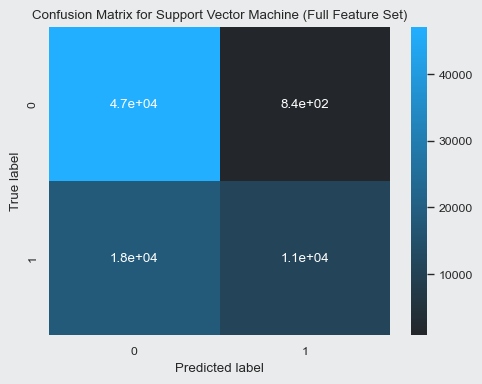

In [162]:
# Evaluate this model
svc_model_label_scaled_result = evaluate_model(
    model=best_svc_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_label_scaled_result.predictions, "Support Vector Machine (Full Feature Set)")

In [163]:
# Compare with respective prototype model
_ = compare_models(svc_model_label_scaled_result, svc_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.224221 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.641848 --> Improvement!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.379010



-- Testing Results --
Accuracy    on Verification Data:	0.376939
Fbeta scroe on Verification Data:	0.975686

              precision    recall  f1-score   support

       False       0.04      0.00      0.00     47913
        True       0.38      0.99      0.55     29378

    accuracy                           0.38     77291
   macro avg       0.21      0.50      0.27     77291
weighted avg       0.17      0.38      0.21     77291

False negatives: 254 (0.865% out of 29378 true positives, 0.329% overall)



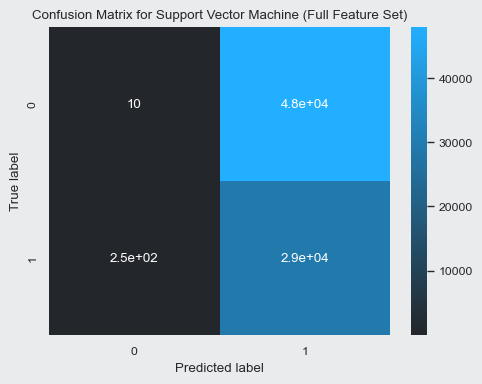

In [164]:
# Evaluate this model
svc_model_1hot_result = evaluate_model(
    model=best_svc_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_1hot_result.predictions, "Support Vector Machine (Full Feature Set)")

In [165]:
# Compare with respective prototype model
_ = compare_models(svc_model_1hot_result, svc_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.176425 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.535061 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686



-- Testing Results --
Accuracy    on Verification Data:	0.630229
Fbeta scroe on Verification Data:	0.029488

              precision    recall  f1-score   support

       False       0.63      1.00      0.77     47913
        True       0.93      0.03      0.06     29378

    accuracy                           0.63     77291
   macro avg       0.78      0.51      0.41     77291
weighted avg       0.74      0.63      0.50     77291

False negatives: 28520 (97.079% out of 29378 true positives, 36.900% overall)



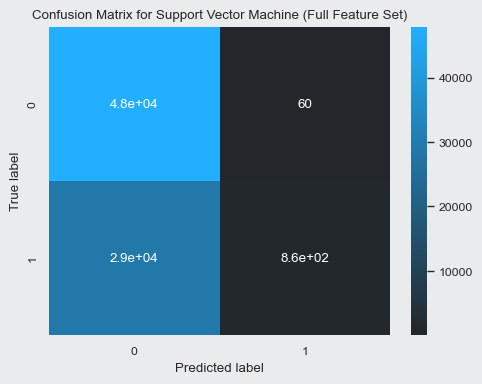

In [166]:
# Evaluate this model
svc_model_1hot_scaled_result = evaluate_model(
    model=best_svc_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_1hot_scaled_result.predictions, "Support Vector Machine (Full Feature Set)")

In [167]:
# Compare with respective prototype model
_ = compare_models(svc_model_1hot_scaled_result, svc_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.769772 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.281771 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.799261


In [168]:
# Compare HPT results with each other
print('\tSupport Vector Machine: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(svc_hpt_label_result, svc_hpt_label_scaled_result)

print('\n\n\tSupport Vector Machine: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(svc_hpt_1hot_result, svc_hpt_1hot_scaled_result)

	Support Vector Machine: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001) with Parameters
{'C': 0.4, 'degree': 3, 'kernel': 'linear', 'tol': 0.0001}
Its score: 0.154789


	Support Vector Machine: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001) with Parameters
{'C': 1.4, 'degree': 3, 'kernel': 'linear', 'tol': 0.0001}
Its score: 0.799261


In [169]:
print('\tSupport Vector Machine: Label Encoded VS One-hot Encoded')
_ = compare_models(svc_hpt_label_result, svc_hpt_1hot_result)

print('\n\n\tSupport Vector Machine: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(svc_hpt_label_scaled_result, svc_hpt_1hot_scaled_result)

	Support Vector Machine: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.644472 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.801600 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001) with Parameters
{'C': 1.4, 'degree': 3, 'kernel': 'linear', 'tol': 0.0001}
Its score: 0.799261


	Support Vector Machine: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.644472 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.801600 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001) with Parameters
{'C': 1.4, 'degree': 3, 'kernel': 'linear', 'tol': 0.0001}
Its score: 0.799261


In [170]:
# Compare full models with each other
print('\tSupport Vector Machine: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(svc_model_label_result, svc_model_label_scaled_result)

print('\n\n\tSupport Vector Machine: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(svc_model_1hot_result, svc_model_1hot_scaled_result)

	Support Vector Machine: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.544817 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.104010 --> Improvement!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.923827


	Support Vector Machine: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.946197 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.253290 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686


In [171]:
print('\tSupport Vector Machine: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(svc_model_label_result, svc_model_1hot_result)

print('\n\n\tSupport Vector Machine: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(svc_model_label_scaled_result, svc_model_1hot_scaled_result)

	Support Vector Machine: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.051859 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.479318 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686


	Support Vector Machine: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.349522 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.122019 --> Improvement!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.379010


In [172]:
# Compare new models with best so far in their respective category
_ = compare_models(svc_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(svc_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(svc_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(svc_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.652831 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.804400 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.008360 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.002800 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.629898 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.799600 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its score: 0.784687

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.014574 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.002000 --> Improvement!

Best model so far:

In [173]:
BEST_HPT_SUB_SCALED_RESULT = svc_hpt_1hot_scaled_result

In [174]:
_ = compare_models(svc_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(svc_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(svc_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(svc_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.099928 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.071483 --> Worsened!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.923827

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.151787 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.550802 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.428553 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.170848 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.778074 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.292867 --> W

In [175]:
BEST_HPT_RESULT = svc_model_1hot_result

In [176]:
# Track overall best model
_ = compare_models(svc_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(svc_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(svc_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(svc_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.038252 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.087811 --> Worsened!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.923827

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.506565 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.191821 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.090111 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.567129 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.856087 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.313840 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.885575


In [177]:
# Store the model results
add_unscaled_model('Support Vector Machine', svc_model_label_result, label_encoded=True)
add_unscaled_model('Support Vector Machine', svc_model_1hot_result, label_encoded=False)
add_scaled_model('Support Vector Machine', svc_model_label_scaled_result, label_encoded=True)
add_scaled_model('Support Vector Machine', svc_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Gradient Boost

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

In [179]:
gradient_boost = GradientBoostingClassifier(random_state=404)                           # base estimator
gb_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [.1, .5, 1., 1.5, 10.],
    'n_estimators': rf_param_grid['n_estimators'],
    'max_depth': rf_param_grid['max_depth'],
    'max_features': ['sqrt', 'log2'],
    'tol': lr_param_grid['tol'],
}

In [180]:
gb_model_label = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
gb_model_label_scaled = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
gb_model_1hot = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
gb_model_1hot_scaled = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [181]:
%time _ = gb_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 6min 15s, sys: 1.76 s, total: 6min 17s
Wall time: 6min 22s


In [182]:
%time _ = gb_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 6min 16s, sys: 2.07 s, total: 6min 18s
Wall time: 6min 24s


In [183]:
%time _ = gb_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 6min 19s, sys: 1.79 s, total: 6min 21s
Wall time: 6min 23s


In [184]:
%time _ = gb_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 6min 13s, sys: 1.47 s, total: 6min 14s
Wall time: 6min 15s


-- Training Results --
Best Parameters:
	learning_rate:	1.0
	loss:	exponential
	max_depth:	5
	max_features:	sqrt
	n_estimators:	20
	tol:	0.0001
Best Score:
	0.986996

-- Testing Results --
Accuracy    on Verification Data:	0.906800
Fbeta scroe on Verification Data:	0.775276

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.77      0.86       950

    accuracy                           0.91      2500
   macro avg       0.93      0.88      0.90      2500
weighted avg       0.91      0.91      0.90      2500

False negatives: 215 (22.632% out of 950 true positives, 8.600% overall)



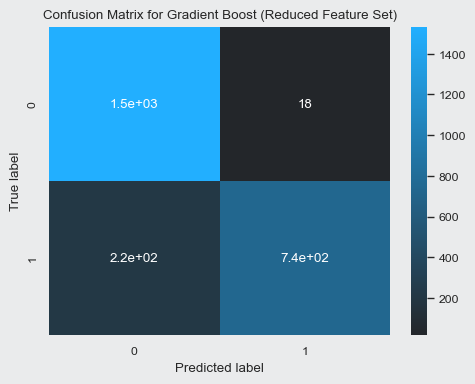

In [185]:
# Evaluate the process
gb_hpt_label_result = evaluate_hpt(
    model=gb_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, gb_hpt_label_result.predictions, 'Gradient Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.0
	loss:	exponential
	max_depth:	5
	max_features:	sqrt
	n_estimators:	20
	tol:	0.0001
Best Score:
	0.986996

-- Testing Results --
Accuracy    on Verification Data:	0.906800
Fbeta scroe on Verification Data:	0.775276

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1550
        True       0.98      0.77      0.86       950

    accuracy                           0.91      2500
   macro avg       0.93      0.88      0.90      2500
weighted avg       0.91      0.91      0.90      2500

False negatives: 215 (22.632% out of 950 true positives, 8.600% overall)



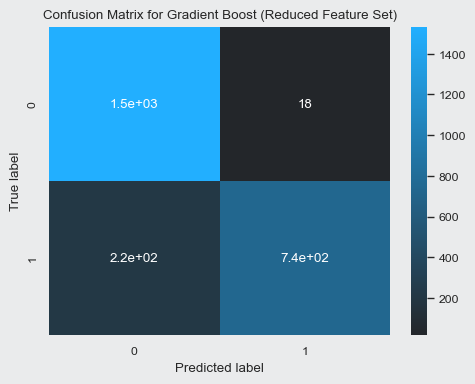

In [186]:
# Evaluate the process
gb_hpt_label_scaled_result = evaluate_hpt(
    model=gb_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, gb_hpt_label_scaled_result.predictions, 'Gradient Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	loss:	log_loss
	max_depth:	10
	max_features:	sqrt
	n_estimators:	10
	tol:	0.0001
Best Score:
	0.990244

-- Testing Results --
Accuracy    on Verification Data:	0.918400
Fbeta scroe on Verification Data:	0.792128

              precision    recall  f1-score   support

       False       0.89      1.00      0.94      1550
        True       0.99      0.79      0.88       950

    accuracy                           0.92      2500
   macro avg       0.94      0.89      0.91      2500
weighted avg       0.93      0.92      0.92      2500

False negatives: 199 (20.947% out of 950 true positives, 7.960% overall)



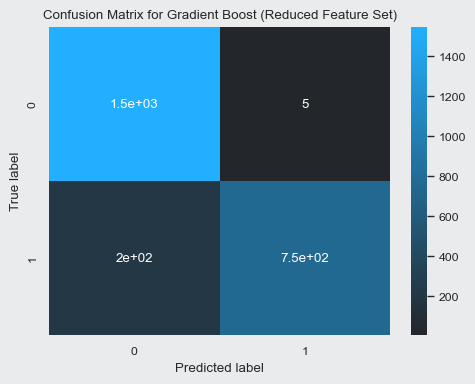

In [187]:
# Evaluate the process
gb_hpt_1hot_result = evaluate_hpt(
    model=gb_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, gb_hpt_1hot_result.predictions, 'Gradient Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	loss:	log_loss
	max_depth:	10
	max_features:	sqrt
	n_estimators:	10
	tol:	0.0001
Best Score:
	0.990244

-- Testing Results --
Accuracy    on Verification Data:	0.918400
Fbeta scroe on Verification Data:	0.792128

              precision    recall  f1-score   support

       False       0.89      1.00      0.94      1550
        True       0.99      0.79      0.88       950

    accuracy                           0.92      2500
   macro avg       0.94      0.89      0.91      2500
weighted avg       0.93      0.92      0.92      2500

False negatives: 199 (20.947% out of 950 true positives, 7.960% overall)



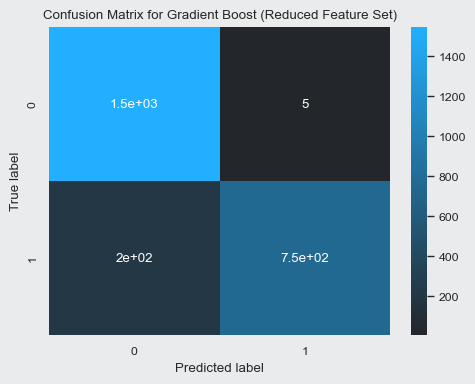

In [188]:
# Evaluate the process
gb_hpt_1hot_scaled_result = evaluate_hpt(
    model=gb_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, gb_hpt_1hot_scaled_result.predictions, 'Gradient Boost (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [189]:
best_gb_label = gb_model_label.best_estimator_
best_gb_label_scaled = gb_model_label_scaled.best_estimator_
best_gb_1hot = gb_model_1hot.best_estimator_
best_gb_1hot_scaled = gb_model_1hot_scaled.best_estimator_

In [190]:
%time _ = best_gb_label.fit(X_training_label, y_training)

CPU times: user 7.04 s, sys: 496 ms, total: 7.53 s
Wall time: 7.58 s


In [191]:
%time _ = best_gb_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 6.52 s, sys: 416 ms, total: 6.94 s
Wall time: 7.04 s


In [192]:
%time _ = best_gb_1hot.fit(X_training_1hot, y_training)

CPU times: user 6.4 s, sys: 531 ms, total: 6.93 s
Wall time: 7.48 s


In [193]:
%time _ = best_gb_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 6.29 s, sys: 418 ms, total: 6.71 s
Wall time: 6.88 s



-- Testing Results --
Accuracy    on Verification Data:	0.933356
Fbeta scroe on Verification Data:	0.842461

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4663 (15.872% out of 29378 true positives, 6.033% overall)



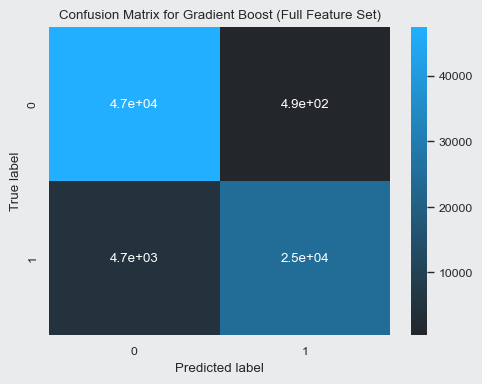

In [194]:
# Evaluate this model
gb_model_label_result = evaluate_model(
    model=best_gb_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_label_result.predictions, "Gradient Boost (Full Feature Set)")

In [195]:
# Compare with respective prototype model
_ = compare_models(gb_model_label_result, gb_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.067185 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.026556 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.842461



-- Testing Results --
Accuracy    on Verification Data:	0.933123
Fbeta scroe on Verification Data:	0.841853

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4681 (15.934% out of 29378 true positives, 6.056% overall)



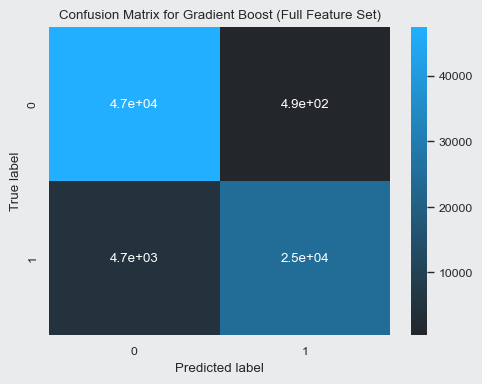

In [196]:
# Evaluate this model
gb_model_label_scaled_result = evaluate_model(
    model=best_gb_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_label_scaled_result.predictions, "Gradient Boost (Full Feature Set)")

In [197]:
# Compare with respective prototype model
_ = compare_models(gb_model_label_scaled_result, gb_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.066577 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.026323 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.841853



-- Testing Results --
Accuracy    on Verification Data:	0.932851
Fbeta scroe on Verification Data:	0.835947

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4857 (16.533% out of 29378 true positives, 6.284% overall)



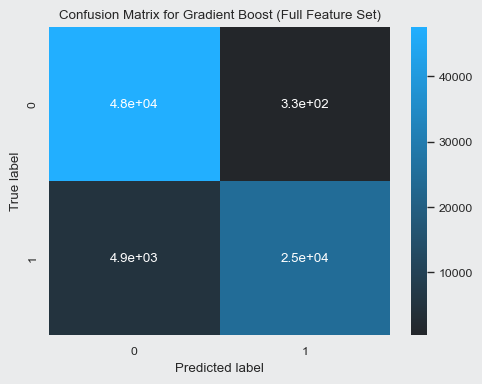

In [198]:
# Evaluate this model
gb_model_1hot_result = evaluate_model(
    model=best_gb_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_1hot_result.predictions, "Gradient Boost (Full Feature Set)")

In [199]:
# Compare with respective prototype model
_ = compare_models(gb_model_1hot_result, gb_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.043819 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.014451 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404)
Its score: 0.835947



-- Testing Results --
Accuracy    on Verification Data:	0.932851
Fbeta scroe on Verification Data:	0.835947

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4857 (16.533% out of 29378 true positives, 6.284% overall)



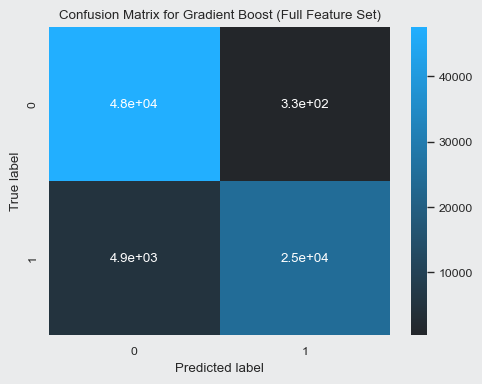

In [200]:
# Evaluate this model
gb_model_1hot_scaled_result = evaluate_model(
    model=best_gb_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_1hot_scaled_result.predictions, "Gradient Boost (Full Feature Set)")

In [201]:
# Compare with respective prototype model
_ = compare_models(gb_model_1hot_scaled_result, gb_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.043819 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.014451 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404)
Its score: 0.835947


In [202]:
# Compare HPT results with each other
print('\tGradient Boost: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(gb_hpt_label_result, gb_hpt_label_scaled_result)

print('\n\n\tGradient Boost: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(gb_hpt_1hot_result, gb_hpt_1hot_scaled_result)

	Gradient Boost: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404) with Parameters
{'learning_rate': 1.0, 'loss': 'exponential', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20, 'tol': 0.0001}
Its score: 0.775276


	Gradient Boost: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404) with Parameters
{'learning_rate': 1.5, 'loss'

In [203]:
print('\tGradient Boost: Label Encoded VS One-hot Encoded')
_ = compare_models(gb_hpt_label_result, gb_hpt_1hot_result)

print('\n\n\tGradient Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(gb_hpt_label_scaled_result, gb_hpt_1hot_scaled_result)

	Gradient Boost: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.016852 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.011600 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404) with Parameters
{'learning_rate': 1.5, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10, 'tol': 0.0001}
Its score: 0.792128


	Gradient Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.016852 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.011600 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404) with Parameters
{'learning_rate': 1.5, 'loss': 'log_loss', 'max_depth': 10, 'max_features

In [204]:
# Compare full models with each other
print('\tGradient Boost: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(gb_model_label_result, gb_model_label_scaled_result)

print('\n\n\tGradient Boost: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(gb_model_1hot_result, gb_model_1hot_scaled_result)

	Gradient Boost: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000608 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000233 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.842461


	Gradient Boost: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=1.5, max_depth=10, max_features='sqrt',
                           n_estimators=10, random_state=404)
Its score: 0.835947


In [205]:
print('\tGradient Boost: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(gb_model_label_result, gb_model_1hot_result)

print('\n\n\tGradient Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(gb_model_label_scaled_result, gb_model_1hot_scaled_result)

	Gradient Boost: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.006514 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000505 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.842461


	Gradient Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.005906 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.000272 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.841853


In [206]:
# Compare new models with best so far in their respective category
_ = compare_models(gb_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(gb_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(gb_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(gb_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.032344 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.008000 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.015493 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.003600 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.009411 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.003200 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=404) with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Its score: 0.784687

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.007441 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008400 --> Improvement!

Best model so fa

In [207]:
BEST_HPT_SUB_SCALED_RESULT = gb_hpt_1hot_scaled_result

In [208]:
_ = compare_models(gb_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(gb_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(gb_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(gb_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.133225 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.556417 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.139739 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.555912 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.034290 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.010027 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=1.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=20,
                           random_state=404)
Its score: 0.841853

-- Model Comparison --
new_results.fbeta - old_results.fbeta 

In [209]:
BEST_HPT_SCALED_RESULT = gb_model_label_scaled_result

In [210]:
# Track overall best model
_ = compare_models(gb_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(gb_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(gb_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(gb_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.133225 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.556417 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.133833 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.556184 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.139739 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.555912 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.139739 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.555912 --> Improvement!

Best model so far:

In [211]:
# Store the model results
add_unscaled_model('Gradient Boost', gb_model_label_result, label_encoded=True)
add_unscaled_model('Gradient Boost', gb_model_1hot_result, label_encoded=False)
add_scaled_model('Gradient Boost', gb_model_label_scaled_result, label_encoded=True)
add_scaled_model('Gradient Boost', gb_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Ada Boost

In [212]:
from sklearn.ensemble import AdaBoostClassifier

In [213]:
ada_boost = AdaBoostClassifier(algorithm='SAMME', random_state=404)                     # base estimator
ab_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'learning_rate': gb_param_grid['learning_rate'],
    'n_estimators': gb_param_grid['n_estimators'],
}

In [214]:
ab_model_label = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
ab_model_label_scaled = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
ab_model_1hot = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
ab_model_1hot_scaled = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [215]:
%time _ = ab_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 7.35 s, sys: 54.9 ms, total: 7.41 s
Wall time: 7.76 s


In [216]:
%time _ = ab_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 7.34 s, sys: 55.3 ms, total: 7.4 s
Wall time: 7.6 s


In [217]:
%time _ = ab_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 8.15 s, sys: 49.9 ms, total: 8.2 s
Wall time: 8.21 s


In [218]:
%time _ = ab_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 8.22 s, sys: 57.5 ms, total: 8.28 s
Wall time: 8.47 s


-- Training Results --
Best Parameters:
	learning_rate:	1.0
	n_estimators:	150
Best Score:
	0.985355

-- Testing Results --
Accuracy    on Verification Data:	0.916400
Fbeta scroe on Verification Data:	0.806617

              precision    recall  f1-score   support

       False       0.89      0.98      0.94      1550
        True       0.97      0.81      0.88       950

    accuracy                           0.92      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.92      0.91      2500

False negatives: 185 (19.474% out of 950 true positives, 7.400% overall)



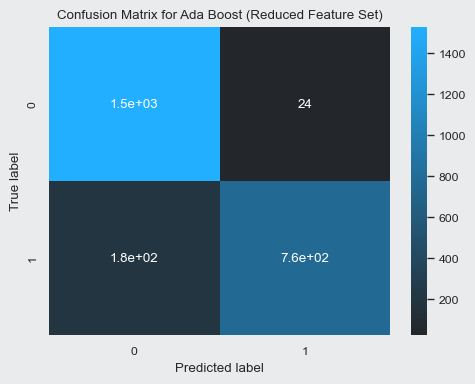

In [219]:
# Evaluate the process
ab_hpt_label_result = evaluate_hpt(
    model=ab_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, ab_hpt_label_result.predictions, 'Ada Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.0
	n_estimators:	150
Best Score:
	0.985355

-- Testing Results --
Accuracy    on Verification Data:	0.916400
Fbeta scroe on Verification Data:	0.806617

              precision    recall  f1-score   support

       False       0.89      0.98      0.94      1550
        True       0.97      0.81      0.88       950

    accuracy                           0.92      2500
   macro avg       0.93      0.89      0.91      2500
weighted avg       0.92      0.92      0.91      2500

False negatives: 185 (19.474% out of 950 true positives, 7.400% overall)



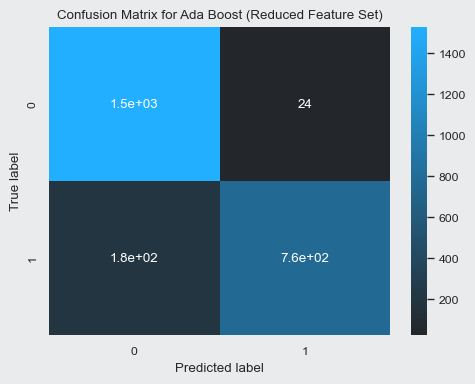

In [220]:
# Evaluate the process
ab_hpt_label_scaled_result = evaluate_hpt(
    model=ab_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, ab_hpt_label_scaled_result.predictions, 'Ada Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.0
	n_estimators:	150
Best Score:
	0.985373

-- Testing Results --
Accuracy    on Verification Data:	0.929200
Fbeta scroe on Verification Data:	0.822450

              precision    recall  f1-score   support

       False       0.90      1.00      0.95      1550
        True       0.99      0.82      0.90       950

    accuracy                           0.93      2500
   macro avg       0.95      0.91      0.92      2500
weighted avg       0.94      0.93      0.93      2500

False negatives: 170 (17.895% out of 950 true positives, 6.800% overall)



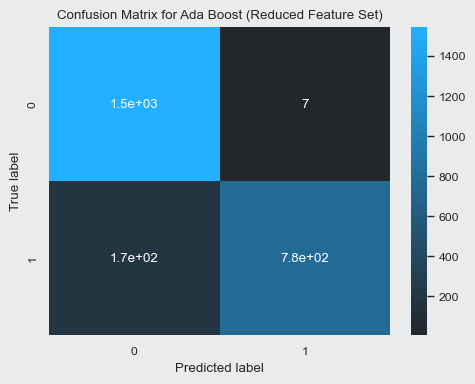

In [221]:
# Evaluate the process
ab_hpt_1hot_result = evaluate_hpt(
    model=ab_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, ab_hpt_1hot_result.predictions, 'Ada Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.0
	n_estimators:	150
Best Score:
	0.985373

-- Testing Results --
Accuracy    on Verification Data:	0.929200
Fbeta scroe on Verification Data:	0.822450

              precision    recall  f1-score   support

       False       0.90      1.00      0.95      1550
        True       0.99      0.82      0.90       950

    accuracy                           0.93      2500
   macro avg       0.95      0.91      0.92      2500
weighted avg       0.94      0.93      0.93      2500

False negatives: 170 (17.895% out of 950 true positives, 6.800% overall)



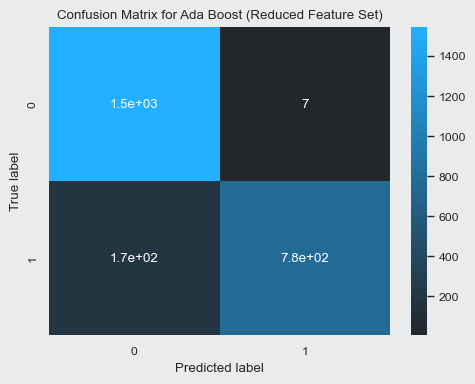

In [222]:
# Evaluate the process
ab_hpt_1hot_scaled_result = evaluate_hpt(
    model=ab_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, ab_hpt_1hot_scaled_result.predictions, 'Ada Boost (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [223]:
best_ab_label = ab_model_label.best_estimator_
best_ab_label_scaled = ab_model_label_scaled.best_estimator_
best_ab_1hot = ab_model_1hot.best_estimator_
best_ab_1hot_scaled = ab_model_1hot_scaled.best_estimator_

In [224]:
%time _ = best_ab_label.fit(X_training_label, y_training)

CPU times: user 1min 8s, sys: 6.16 s, total: 1min 14s
Wall time: 1min 14s


In [225]:
%time _ = best_ab_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 1min 7s, sys: 5.88 s, total: 1min 13s
Wall time: 1min 13s


In [226]:
%time _ = best_ab_1hot.fit(X_training_1hot, y_training)

CPU times: user 1min 44s, sys: 17.3 s, total: 2min 2s
Wall time: 2min 3s


In [227]:
%time _ = best_ab_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 1min 44s, sys: 16.4 s, total: 2min 1s
Wall time: 2min 2s



-- Testing Results --
Accuracy    on Verification Data:	0.931674
Fbeta scroe on Verification Data:	0.830724

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 5012 (17.060% out of 29378 true positives, 6.485% overall)



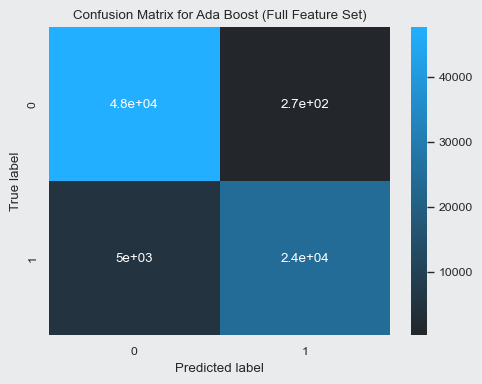

In [228]:
# Evaluate this model
ab_model_label_result = evaluate_model(
    model=best_ab_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_label_result.predictions, "Ada Boost (Full Feature Set)")

In [229]:
# Compare with respective prototype model
_ = compare_models(ab_model_label_result, ab_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.024107 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.015274 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724



-- Testing Results --
Accuracy    on Verification Data:	0.931674
Fbeta scroe on Verification Data:	0.830724

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 5012 (17.060% out of 29378 true positives, 6.485% overall)



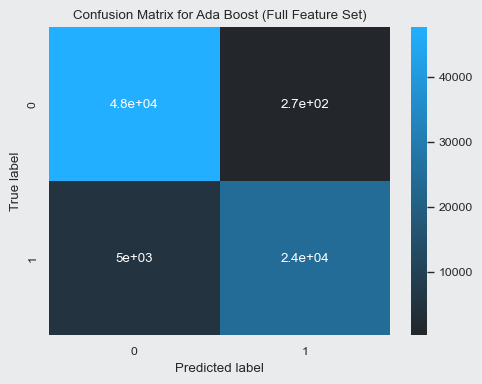

In [230]:
# Evaluate this model
ab_model_label_scaled_result = evaluate_model(
    model=best_ab_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_label_scaled_result.predictions, "Ada Boost (Full Feature Set)")

In [231]:
# Compare with respective prototype model
_ = compare_models(ab_model_label_scaled_result, ab_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.024107 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.015274 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724



-- Testing Results --
Accuracy    on Verification Data:	0.930626
Fbeta scroe on Verification Data:	0.827147

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 5118 (17.421% out of 29378 true positives, 6.622% overall)



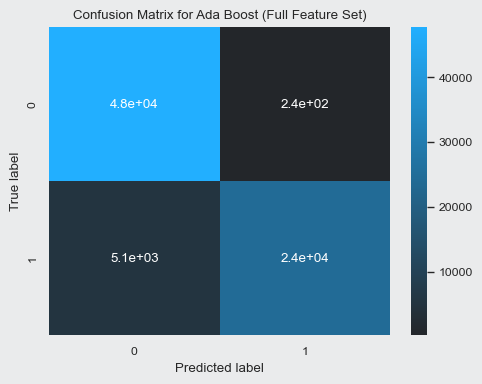

In [232]:
# Evaluate this model
ab_model_1hot_result = evaluate_model(
    model=best_ab_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_1hot_result.predictions, "Ada Boost (Full Feature Set)")

In [233]:
# Compare with respective prototype model
_ = compare_models(ab_model_1hot_result, ab_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.004697 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.001426 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.827147



-- Testing Results --
Accuracy    on Verification Data:	0.930626
Fbeta scroe on Verification Data:	0.827147

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     47913
        True       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 5118 (17.421% out of 29378 true positives, 6.622% overall)



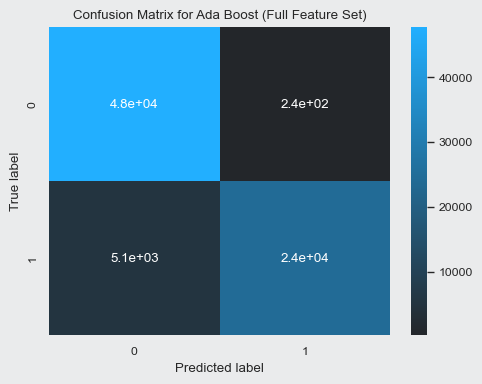

In [234]:
# Evaluate this model
ab_model_1hot_scaled_result = evaluate_model(
    model=best_ab_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_1hot_scaled_result.predictions, "Ada Boost (Full Feature Set)")

In [235]:
# Compare with respective prototype model
_ = compare_models(ab_model_1hot_scaled_result, ab_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.004697 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.001426 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.827147


In [236]:
# Compare HPT results with each other
print('\tAda Boost: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(ab_hpt_label_result, ab_hpt_label_scaled_result)

print('\n\n\tAda Boost: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(ab_hpt_1hot_result, ab_hpt_1hot_scaled_result)

	Ada Boost: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.806617


	Ada Boost: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.822450


In [237]:
print('\tAda Boost : Label Encoded VS One-hot Encoded')
_ = compare_models(ab_hpt_label_result, ab_hpt_1hot_result)

print('\n\n\tAda Boost : Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(ab_hpt_label_scaled_result, ab_hpt_1hot_scaled_result)

	Ada Boost : Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.015833 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.012800 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.822450


	Ada Boost : Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.015833 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.012800 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.822450


In [238]:
# Compare full models with each other
print('\tAda Boost: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(ab_model_label_result, ab_model_label_scaled_result)

print('\n\n\tAda Boost: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(ab_model_1hot_result, ab_model_1hot_scaled_result)

	Ada Boost: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724


	Ada Boost: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.827147


In [239]:
print('\tAda Boost: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(ab_model_label_result, ab_model_1hot_result)

print('\n\n\tAda Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(ab_model_label_scaled_result, ab_model_1hot_scaled_result)

	Ada Boost: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.003577 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.001048 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724


	Ada Boost: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.003577 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.001048 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724


In [240]:
# Compare new models with best so far in their respective category
_ = compare_models(ab_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(ab_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(ab_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(ab_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.001004 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.001600 --> Improvement!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.807620

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.014829 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.014400 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.822450

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.021929 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.006400 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.806617

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.037763 --> Improvement!
n

In [241]:
BEST_HPT_SUB_RESULT = ab_hpt_1hot_result
BEST_HPT_SUB_SCALED_RESULT = ab_hpt_1hot_scaled_result

In [242]:
_ = compare_models(ab_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(ab_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(ab_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(ab_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.144962 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.554735 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.148539 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.553687 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.023161 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008578 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404)
Its score: 0.830724

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.019584 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.007530 --> Improvement!

Best model so 

In [243]:
BEST_HPT_SCALED_RESULT = ab_model_1hot_scaled_result

In [244]:
# Track overall best model
_ = compare_models(ab_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(ab_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(ab_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(ab_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.144962 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.554735 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.144962 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.554735 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.148539 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.553687 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.148539 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.553687 --> Improvement!

Best model so far:

In [245]:
# Store the model results
add_unscaled_model('Ada Boost', ab_model_label_result, label_encoded=True)
add_unscaled_model('Ada Boost', ab_model_1hot_result, label_encoded=False)
add_scaled_model('Ada Boost', ab_model_label_scaled_result, label_encoded=True)
add_scaled_model('Ada Boost', ab_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Artificial Neural Network

In [246]:
from sklearn.neural_network import MLPClassifier

In [247]:
neural_network = MLPClassifier(                                                             # base estimator
    solver='adam',
    learning_rate='constant',
    early_stopping=True,
    random_state=404
)
nn_param_grid = {                                                                           # parameter grid for hyperparameter tuning
    'hidden_layer_sizes': [(128,), (128, 128), (64, 64, 32), (124, 64, 32), (64, 64, 64, 32), (64, 32, 16)],
    'activation': ['relu', 'logistic', 'tanh'],
    'alpha': [1.e-4, 1.e-3, 1.e-2],
    'learning_rate_init': ab_param_grid['learning_rate'],
    'tol': gb_param_grid['tol'],
}

In [248]:
nn_model_label = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nn_model_label_scaled = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nn_model_1hot = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nn_model_1hot_scaled = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [249]:
%time _ = nn_model_label.fit(X_training_label_sub, y_training_label_sub)

CPU times: user 1h 27min 35s, sys: 1min 7s, total: 1h 28min 42s
Wall time: 11min 31s


In [250]:
%time _ = nn_model_label_scaled.fit(X_training_label_scaled_sub, y_training_label_scaled_sub)

CPU times: user 1h 31min 27s, sys: 1min 9s, total: 1h 32min 36s
Wall time: 12min 5s


In [251]:
%time _ = nn_model_1hot.fit(X_training_1hot_sub, y_training_1hot_sub)

CPU times: user 1h 36min 39s, sys: 1min 15s, total: 1h 37min 54s
Wall time: 12min 49s


In [252]:
%time _ = nn_model_1hot_scaled.fit(X_training_1hot_scaled_sub, y_training_1hot_scaled_sub)

CPU times: user 1h 37min 8s, sys: 1min 14s, total: 1h 38min 23s
Wall time: 12min 52s


-- Training Results --
Best Parameters:
	activation:	relu
	alpha:	0.0001
	hidden_layer_sizes:	(128,)
	learning_rate_init:	1.0
	tol:	0.0001
Best Score:
	0.969528

-- Testing Results --
Accuracy    on Verification Data:	0.897600
Fbeta scroe on Verification Data:	0.864229

              precision    recall  f1-score   support

       False       0.92      0.92      0.92      1550
        True       0.87      0.86      0.87       950

    accuracy                           0.90      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.90      0.90      0.90      2500

False negatives: 129 (13.579% out of 950 true positives, 5.160% overall)



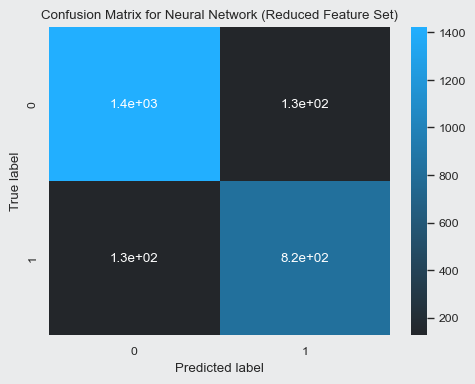

In [253]:
# Evaluate the process
nn_hpt_label_result = evaluate_hpt(
    model=nn_model_label,
    X_test=X_test_label_sub,
    y_true=y_true_label_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_sub, nn_hpt_label_result.predictions, 'Neural Network (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	activation:	relu
	alpha:	0.0001
	hidden_layer_sizes:	(128,)
	learning_rate_init:	1.0
	tol:	0.0001
Best Score:
	0.969528

-- Testing Results --
Accuracy    on Verification Data:	0.897600
Fbeta scroe on Verification Data:	0.864229

              precision    recall  f1-score   support

       False       0.92      0.92      0.92      1550
        True       0.87      0.86      0.87       950

    accuracy                           0.90      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.90      0.90      0.90      2500

False negatives: 129 (13.579% out of 950 true positives, 5.160% overall)



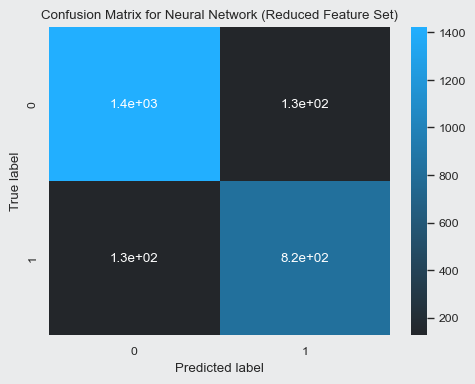

In [254]:
# Evaluate the process
nn_hpt_label_scaled_result = evaluate_hpt(
    model=nn_model_label_scaled,
    X_test=X_test_label_scaled_sub,
    y_true=y_true_label_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_label_scaled_sub, nn_hpt_label_scaled_result.predictions, 'Neural Network (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	activation:	relu
	alpha:	0.01
	hidden_layer_sizes:	(128,)
	learning_rate_init:	0.1
	tol:	0.0001
Best Score:
	0.978687

-- Testing Results --
Accuracy    on Verification Data:	0.906000
Fbeta scroe on Verification Data:	0.758637

              precision    recall  f1-score   support

       False       0.87      1.00      0.93      1550
        True       0.99      0.76      0.86       950

    accuracy                           0.91      2500
   macro avg       0.93      0.88      0.89      2500
weighted avg       0.92      0.91      0.90      2500

False negatives: 231 (24.316% out of 950 true positives, 9.240% overall)



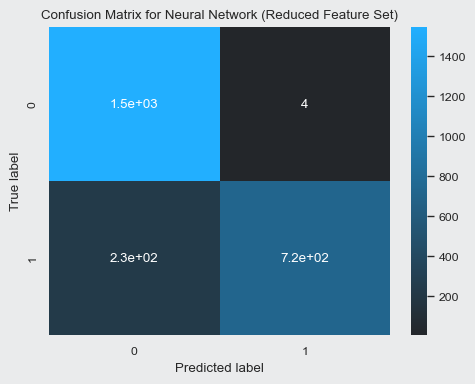

In [255]:
# Evaluate the process
nn_hpt_1hot_result = evaluate_hpt(
    model=nn_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true_1hot_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_sub, nn_hpt_1hot_result.predictions, 'Neural Network (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	activation:	relu
	alpha:	0.01
	hidden_layer_sizes:	(128,)
	learning_rate_init:	0.1
	tol:	0.0001
Best Score:
	0.978687

-- Testing Results --
Accuracy    on Verification Data:	0.906000
Fbeta scroe on Verification Data:	0.758637

              precision    recall  f1-score   support

       False       0.87      1.00      0.93      1550
        True       0.99      0.76      0.86       950

    accuracy                           0.91      2500
   macro avg       0.93      0.88      0.89      2500
weighted avg       0.92      0.91      0.90      2500

False negatives: 231 (24.316% out of 950 true positives, 9.240% overall)



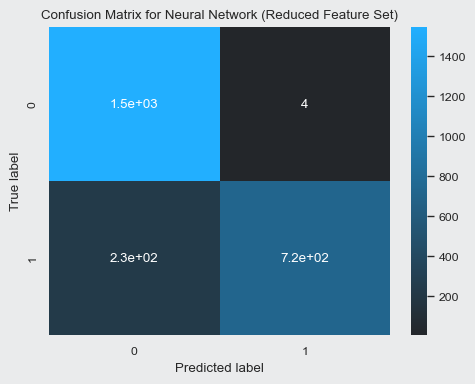

In [256]:
# Evaluate the process
nn_hpt_1hot_scaled_result = evaluate_hpt(
    model=nn_model_1hot_scaled,
    X_test=X_test_1hot_scaled_sub,
    y_true=y_true_1hot_scaled_sub,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true_1hot_scaled_sub, nn_hpt_1hot_scaled_result.predictions, 'Neural Network (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [257]:
best_nn_label = nn_model_label.best_estimator_
best_nn_label_scaled = nn_model_label_scaled.best_estimator_
best_nn_1hot = nn_model_1hot.best_estimator_
best_nn_1hot_scaled = nn_model_1hot_scaled.best_estimator_

In [258]:
%time _ = best_nn_label.fit(X_training_label, y_training)

CPU times: user 4min 17s, sys: 4.05 s, total: 4min 21s
Wall time: 36.7 s


In [259]:
%time _ = best_nn_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 7min 24s, sys: 5.83 s, total: 7min 30s
Wall time: 1min


In [260]:
%time _ = best_nn_1hot.fit(X_training_1hot, y_training)

CPU times: user 6min 55s, sys: 7.21 s, total: 7min 2s
Wall time: 59.6 s


In [261]:
%time _ = best_nn_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 8min 3s, sys: 9.13 s, total: 8min 12s
Wall time: 1min 9s



-- Testing Results --
Accuracy    on Verification Data:	0.890194
Fbeta scroe on Verification Data:	0.718804

              precision    recall  f1-score   support

       False       0.85      1.00      0.92     47913
        True       0.99      0.72      0.83     29378

    accuracy                           0.89     77291
   macro avg       0.92      0.86      0.88     77291
weighted avg       0.91      0.89      0.89     77291

False negatives: 8319 (28.317% out of 29378 true positives, 10.763% overall)



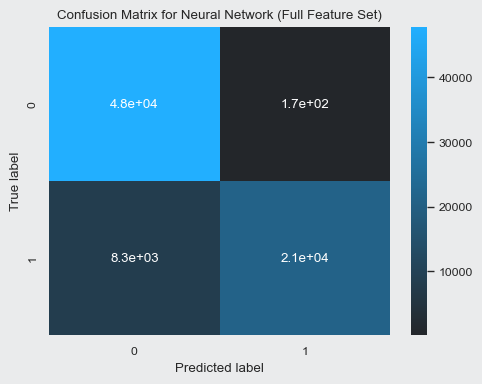

In [262]:
# Evaluate this model
nn_model_label_result = evaluate_model(
    model=best_nn_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_label_result.predictions, "Neural Network (Full Feature Set)")

In [263]:
# Compare with respective prototype model
_ = compare_models(nn_model_label_result, nn_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.145425 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.007406 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404)
Its score: 0.864229



-- Testing Results --
Accuracy    on Verification Data:	0.724237
Fbeta scroe on Verification Data:	0.276545

              precision    recall  f1-score   support

       False       0.69      1.00      0.82     47913
        True       1.00      0.27      0.43     29378

    accuracy                           0.72     77291
   macro avg       0.85      0.64      0.62     77291
weighted avg       0.81      0.72      0.67     77291

False negatives: 21312 (72.544% out of 29378 true positives, 27.574% overall)



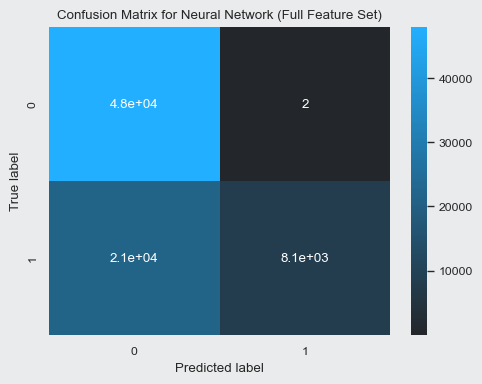

In [264]:
# Evaluate this model
nn_model_label_scaled_result = evaluate_model(
    model=best_nn_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_label_scaled_result.predictions, "Neural Network (Full Feature Set)")

In [265]:
# Compare with respective prototype model
_ = compare_models(nn_model_label_scaled_result, nn_hpt_label_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.587683 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.173363 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404)
Its score: 0.864229



-- Testing Results --
Accuracy    on Verification Data:	0.899911
Fbeta scroe on Verification Data:	0.744887

              precision    recall  f1-score   support

       False       0.86      1.00      0.93     47913
        True       0.99      0.74      0.85     29378

    accuracy                           0.90     77291
   macro avg       0.93      0.87      0.89     77291
weighted avg       0.91      0.90      0.90     77291

False negatives: 7549 (25.696% out of 29378 true positives, 9.767% overall)



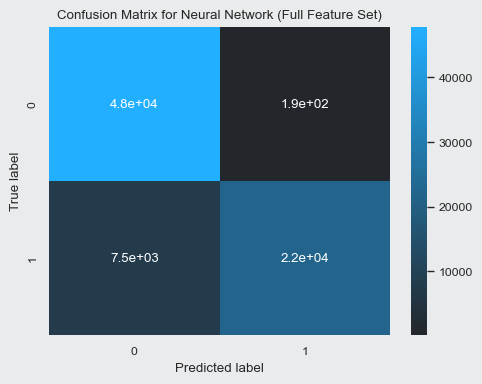

In [266]:
# Evaluate this model
nn_model_1hot_result = evaluate_model(
    model=best_nn_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_1hot_result.predictions, "Neural Network (Full Feature Set)")

In [267]:
# Compare with respective prototype model
_ = compare_models(nn_model_1hot_result, nn_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.013750 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006089 --> Worsened!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.758637



-- Testing Results --
Accuracy    on Verification Data:	0.921660
Fbeta scroe on Verification Data:	0.818268

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.97      0.82      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.94      0.90      0.91     77291
weighted avg       0.93      0.92      0.92     77291

False negatives: 5377 (18.303% out of 29378 true positives, 6.957% overall)



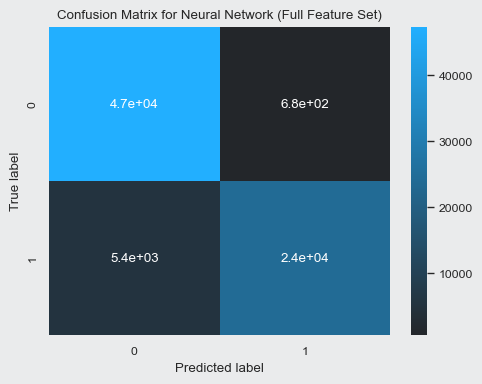

In [268]:
# Evaluate this model
nn_model_1hot_scaled_result = evaluate_model(
    model=best_nn_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_1hot_scaled_result.predictions, "Neural Network (Full Feature Set)")

In [269]:
# Compare with respective prototype model
_ = compare_models(nn_model_1hot_scaled_result, nn_hpt_1hot_scaled_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.059631 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.015660 --> Improvement!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.818268


In [270]:
# Compare HPT results with each other
print('\tNeural Network: Label Encoded VS Label Encoded + Scaled')
_ = compare_models(nn_hpt_label_result, nn_hpt_label_scaled_result)

print('\n\n\tNeural Network: One-hot Encoded VS One-hot Encoded + Scaled')
_ = compare_models(nn_hpt_1hot_result, nn_hpt_1hot_scaled_result)

	Neural Network: Label Encoded VS Label Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404) with Parameters
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 1.0, 'tol': 0.0001}
Its score: 0.864229


	Neural Network: One-hot Encoded VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404) with Parameters
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.1, 'tol': 0.0001}
Its score: 0

In [271]:
print('\tNeural Network: Label Encoded VS One-hot Encoded')
_ = compare_models(nn_hpt_label_result, nn_hpt_1hot_result)

print('\n\n\tNeural Network: Label Encoded + Scaled VS One-hot Encoded + Scaled')
_ = compare_models(nn_hpt_label_scaled_result, nn_hpt_1hot_scaled_result)

	Neural Network: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.105592 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.008400 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404) with Parameters
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 1.0, 'tol': 0.0001}
Its score: 0.864229


	Neural Network: Label Encoded + Scaled VS One-hot Encoded + Scaled
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.105592 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.008400 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404) with Parameters
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 1.0, 'tol': 0.0001}
Its score: 0.8

In [272]:
# Compare full models with each other
print('\tNeural Network: Label Encoded VS Label Encoded + Scaled (Full Featureset)')
_ = compare_models(nn_model_label_result, nn_model_label_scaled_result)

print('\n\n\tNeural Network: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(nn_model_1hot_result, nn_model_1hot_scaled_result)

	Neural Network: Label Encoded VS Label Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.442258 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.165957 --> Improvement!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404)
Its score: 0.718804


	Neural Network: One-hot Encoded VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.073381 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.021749 --> Worsened!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.818268


In [273]:
print('\tNeural Network: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(nn_model_label_result, nn_model_1hot_result)

print('\n\n\tNeural Network: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)')
_ = compare_models(nn_model_label_scaled_result, nn_model_1hot_scaled_result)

	Neural Network: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.026084 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.009717 --> Worsened!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.744887


	Neural Network: Label Encoded + Scaled VS One-hot Encoded + Scaled (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.541722 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.197423 --> Worsened!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.818268


In [274]:
# Compare new models with best so far in their respective category
_ = compare_models(nn_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(nn_hpt_1hot_result, BEST_HPT_SUB_RESULT)
print()
_ = compare_models(nn_hpt_label_scaled_result, BEST_SCALED_HPT_SUB_RESULT)
print()
_ = compare_models(nn_hpt_1hot_scaled_result, BEST_SCALED_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.041779 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.031600 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.0, random_state=404) with Parameters
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 1.0, 'tol': 0.0001}
Its score: 0.864229

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.063813 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.023200 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=150, random_state=404) with Parameters
{'learning_rate': 1.0, 'n_estimators': 150}
Its score: 0.822450

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.079541 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.012400 --> Worsened!

Best model so far:
MLPClassifier(early_stopping=True, hidden_layer_s

In [275]:
BEST_HPT_SUB_RESULT = nn_hpt_label_result
BEST_HPT_SUB_SCALED_RESULT = nn_model_label_scaled_result

In [276]:
_ = compare_models(nn_model_label_result, BEST_HPT_RESULT)
print()
_ = compare_models(nn_model_1hot_result, BEST_HPT_RESULT)
print()
_ = compare_models(nn_model_label_scaled_result, BEST_SCALED_HPT_RESULT)
print()
_ = compare_models(nn_model_1hot_scaled_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.256882 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.513255 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.230799 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.522972 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.531017 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.198859 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=404)
Its score: 0.807563

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.010705 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.001436 -->

In [277]:
BEST_HPT_SCALED_RESULT = nn_model_1hot_scaled_result

In [278]:
# Track overall best model
_ = compare_models(nn_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(nn_model_label_scaled_result, results(top_overall(1)[0]))
print()
_ = compare_models(nn_model_1hot_result, results(top_overall(1)[0]))
print()
_ = compare_models(nn_model_1hot_scaled_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.256882 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.513255 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.699141 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.347298 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.230799 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.522972 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.975686

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.157418 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.544721 --> Improvement!

Best model so far:

In [279]:
# Store the model results
add_unscaled_model('Neural Network', nn_model_label_result, label_encoded=True)
add_unscaled_model('Neural Network', nn_model_1hot_result, label_encoded=False)
add_scaled_model('Neural Network', nn_model_label_scaled_result, label_encoded=True)
add_scaled_model('Neural Network', nn_model_1hot_scaled_result, label_encoded=False)

--------------------------------------------------------------------------------

## Voting Classification

First, let's have a look at our best models.

In [280]:
num_models = 4
best_label_scaled_models = top_scaled(num_models, label_encoded=True)         # top n models on scaled data
best_label_unscaled_models = top_unscaled(num_models, label_encoded=True)     # top n models on unscaled data
best_1hot_scaled_models = top_scaled(num_models, label_encoded=False)         # top n models on scaled data
best_1hot_unscaled_models = top_unscaled(num_models, label_encoded=False)     # top n models on unscaled data

# For confirmation, print the top n for the scaled case:
list(map(name, best_label_scaled_models))

['Gradient Boost', 'Naive Bayes', 'KNN', 'Ada Boost']

In [281]:
list(map(name, best_label_unscaled_models))

['Support Vector Machine', 'Gradient Boost', 'Ada Boost', 'KNN']

Unfortunately, `SVC` doesn't support probability prediction, so it can't be used in the `VotingClassifier`.
We need to remove it from our list of best models, if it is contained...

In [282]:
best_label_scaled_models = list(top_scaled(num_models+1, label_encoded=True) | where (lambda model: "Support Vector" not in name(model)))[:num_models]
best_label_unscaled_models = list(top_unscaled(num_models+1, label_encoded=True) | where (lambda model: "Support Vector" not in name(model)))[:num_models]
best_1hot_scaled_models = list(top_scaled(num_models+1, label_encoded=False) | where (lambda model: "Support Vector" not in name(model)))[:num_models]
best_1hot_unscaled_models = list(top_unscaled(num_models+1, label_encoded=False) | where (lambda model: "Support Vector" not in name(model)))[:num_models]

In [283]:
list(map(name, best_label_scaled_models))

['Gradient Boost', 'Naive Bayes', 'KNN', 'Ada Boost']

In [284]:
list(map(name, best_label_unscaled_models))

['Gradient Boost', 'Ada Boost', 'KNN', 'Random Forest']

In [285]:
from sklearn.ensemble import VotingClassifier

In [286]:
# Construct the voting classifier with the best models
def make_voting_classifier(models):
    return VotingClassifier(
        list(
            map(
                lambda model: (name(model), results(model).model),
                models
            )
        ),
        voting='soft',
        n_jobs=-1
    )
compound_label_unscaled = make_voting_classifier(best_label_unscaled_models)
compound_label_scaled = make_voting_classifier(best_label_scaled_models)
compound_1hot_unscaled = make_voting_classifier(best_1hot_unscaled_models)
compound_1hot_scaled = make_voting_classifier(best_1hot_scaled_models)

In [287]:
# Train the classifiers

%time _ = compound_label_unscaled.fit(X_training_label, y_training)

CPU times: user 379 ms, sys: 1.36 s, total: 1.74 s
Wall time: 1min 33s


In [288]:
%time _ = compound_label_scaled.fit(X_training_label_scaled, y_training)

CPU times: user 195 ms, sys: 643 ms, total: 837 ms
Wall time: 1min 17s


In [289]:
%time _ = compound_1hot_unscaled.fit(X_training_1hot, y_training)

CPU times: user 1.42 s, sys: 2.89 s, total: 4.31 s
Wall time: 18min 50s


In [290]:
%time _ = compound_1hot_scaled.fit(X_training_1hot_scaled, y_training)

CPU times: user 514 ms, sys: 497 ms, total: 1.01 s
Wall time: 7min 20s



-- Testing Results --
Accuracy    on Verification Data:	0.926951
Fbeta scroe on Verification Data:	0.818481

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.82      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5374 (18.293% out of 29378 true positives, 6.953% overall)



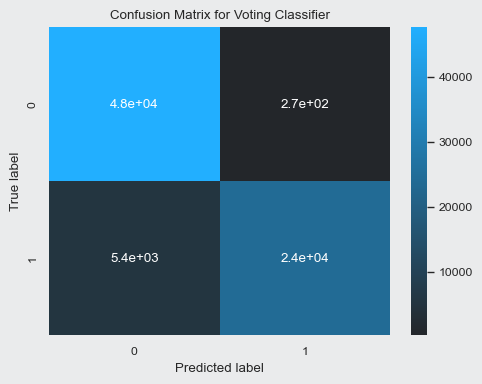

In [291]:
# Evaluate the result
compound_label_unscaled_result = evaluate_model(
    model=compound_label_unscaled,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, compound_label_unscaled_result.predictions, "Voting Classifier")


-- Testing Results --
Accuracy    on Verification Data:	0.933149
Fbeta scroe on Verification Data:	0.842188

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4671 (15.900% out of 29378 true positives, 6.043% overall)



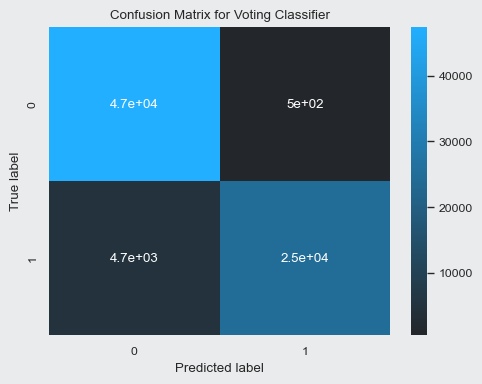

In [292]:
# Evaluate the result (on scaled data)
compound_label_scaled_result = evaluate_model(
    model=compound_label_scaled,
    X_test=X_test_label_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, compound_label_scaled_result.predictions, "Voting Classifier")


-- Testing Results --
Accuracy    on Verification Data:	0.928038
Fbeta scroe on Verification Data:	0.820786

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

False negatives: 5306 (18.061% out of 29378 true positives, 6.865% overall)



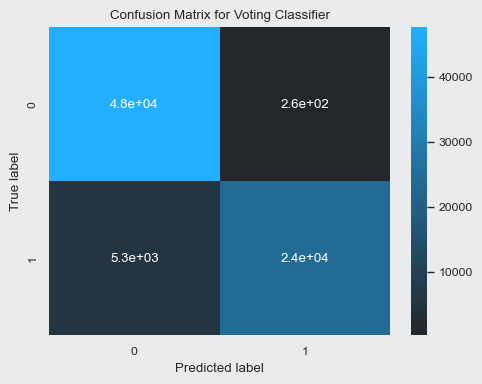

In [293]:
# Evaluate the result
compound_1hot_unscaled_result = evaluate_model(
    model=compound_1hot_unscaled,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, compound_1hot_unscaled_result.predictions, "Voting Classifier")


-- Testing Results --
Accuracy    on Verification Data:	0.925890
Fbeta scroe on Verification Data:	0.833851

              precision    recall  f1-score   support

       False       0.91      0.98      0.94     47913
        True       0.97      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.92     77291

False negatives: 4915 (16.730% out of 29378 true positives, 6.359% overall)



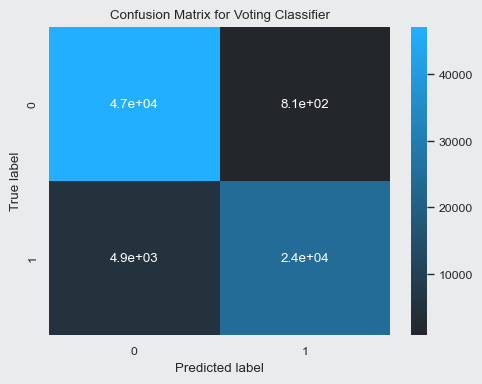

In [294]:
# Evaluate the result (on scaled data)
compound_1hot_scaled_result = evaluate_model(
    model=compound_1hot_scaled,
    X_test=X_test_1hot_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
# Display the confusion matrix
confusion_matrix(y_true, compound_1hot_scaled_result.predictions, "Voting Classifier")

--------------------------------------------------------------------------------

To next notebook: [Network Traffic ML Part 2](./network-traffic-ml-part2.ipynb)